<a href="https://colab.research.google.com/github/pei0217/fin_hw4/blob/main/fin_hw4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[*********************100%***********************]  1 of 1 completed

Price                          Close
Ticker                       2317.TW
Date                                
2020-01-02 00:00:00+00:00  90.800003
2020-01-03 00:00:00+00:00  91.599998
2020-01-06 00:00:00+00:00  90.500000
2020-01-07 00:00:00+00:00  89.099998
2020-01-08 00:00:00+00:00  86.500000
Epoch 1/25



/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


14/14 ━━━━━━━━━━━━━━━━━━━━ 5s 85ms/step - loss: 0.1669 - val_loss: 0.0017
Epoch 2/25
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 108ms/step - loss: 0.0121 - val_loss: 0.0017
Epoch 3/25
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - loss: 0.0072 - val_loss: 0.0024
Epoch 4/25
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - loss: 0.0047 - val_loss: 0.0014
Epoch 5/25
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - loss: 0.0044 - val_loss: 0.0016
Epoch 6/25
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 89ms/step - loss: 0.0039 - val_loss: 0.0015
Epoch 7/25
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 93ms/step - loss: 0.0033 - val_loss: 0.0014
Epoch 8/25
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 92ms/step - loss: 0.0037 - val_loss: 0.0013
Epoch 9/25
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - loss: 0.0040 - val_loss: 0.0013
Epoch 10/25
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - loss: 0.0031 - val_loss: 0.0013
Epoch 11/25
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - loss: 0.0031 - val_loss: 0.0013
Epoch 12/25
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - loss: 0.0038 - val_

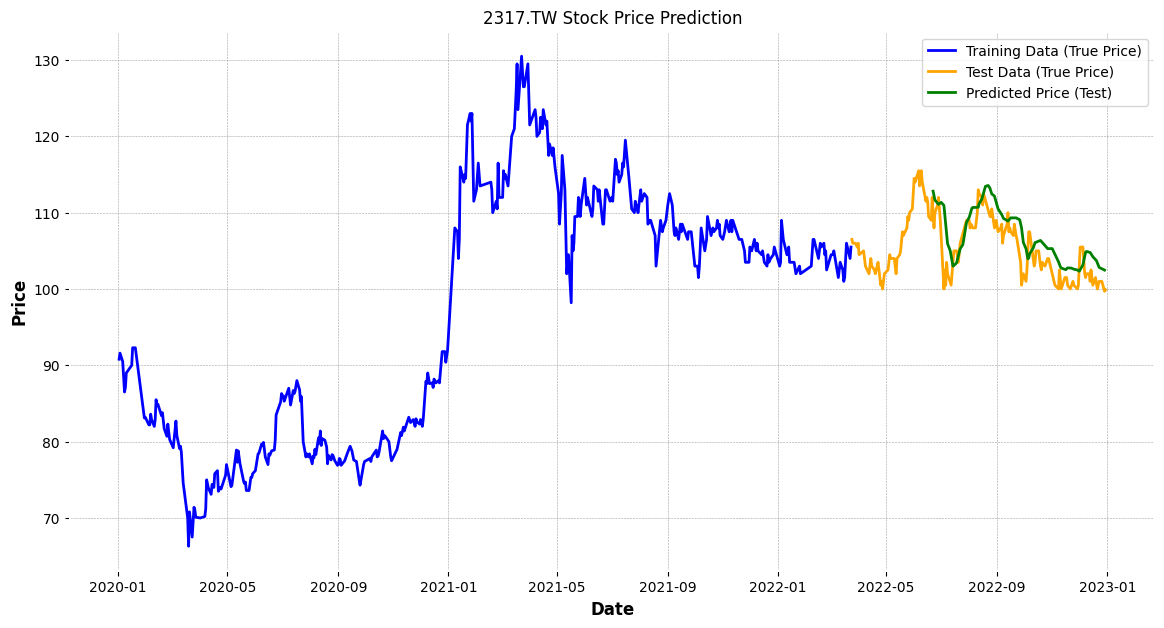

In [ ]:
import yfinance as yf
import pandas as pd

# 抓取台積電 (2330.TW) 的歷史資料
ticker = "2317.TW"
df = yf.download(ticker, start="2020-01-01", end="2023-01-01")

# 選擇收盤價來進行預測
df = df[['Close']]
df.dropna(inplace=True)
print(df.head())

import numpy as np
from sklearn.preprocessing import MinMaxScaler

# 使用 MinMaxScaler 將資料標準化
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(df)

# 建立輸入序列 (X) 和輸出值 (y)
def create_dataset(dataset, time_step=60):
    X, y = [], []
    for i in range(len(dataset)-time_step-1):
        a = dataset[i:(i+time_step), 0]  # 過去 time_step 天的資料
        X.append(a)
        y.append(dataset[i + time_step, 0])  # 第 time_step+1 天的資料
    return np.array(X), np.array(y)

time_step = 60
X, y = create_dataset(scaled_data, time_step)

# 將資料切分成訓練集和測試集
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# 將資料形狀調整為 [samples, time steps, features]
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM

model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(time_step, 1)),
    LSTM(50, return_sequences=False),
    Dense(25),
    Dense(1)
])

model.compile(optimizer='adam', loss='mean_squared_error')

# 訓練模型
model.fit(X_train, y_train, batch_size=32, epochs=25, validation_split=0.2)

# 使用模型進行預測
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

# 將預測結果反標準化
train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)
y_train = scaler.inverse_transform(y_train.reshape(-1, 1))
y_test = scaler.inverse_transform(y_test.reshape(-1, 1))



# 繪製訓練資料和測試資料的真實價格
plt.figure(figsize=(14, 7))
plt.plot(df.index[:train_size], scaler.inverse_transform(scaled_data[:train_size]), label='Training Data (True Price)', color='blue')
plt.plot(df.index[train_size:], scaler.inverse_transform(scaled_data[train_size:]), label='Test Data (True Price)', color='orange')

# 將預測結果與原始資料進行對齊
train_predict_plot = np.empty_like(scaled_data)
train_predict_plot[:, :] = np.nan
train_predict_plot[time_step:train_size + time_step, :] = train_predict

test_predict_plot = np.empty_like(scaled_data)
test_predict_plot[:, :] = np.nan
# 修正索引範圍，讓預測結果與測試資料對齊
test_start_index = train_size + time_step
test_predict_plot[test_start_index:test_start_index + len(test_predict), :] = test_predict

# 繪製預測結果
plt.plot(df.index, test_predict_plot, label='Predicted Price (Test)', color='green')
plt.xlabel('Date')
plt.ylabel('Price')
plt.title(f'{ticker} Stock Price Prediction')
plt.legend()
plt.show()


[*********************100%***********************]  1 of 1 completed


數據預覽：
                           Adj Close_AAPL  Close_AAPL  High_AAPL   Low_AAPL  \
Date                                                                          
2020-01-02 00:00:00+00:00       72.876114   75.087502  75.150002  73.797501   
2020-01-03 00:00:00+00:00       72.167603   74.357498  75.144997  74.125000   
2020-01-06 00:00:00+00:00       72.742668   74.949997  74.989998  73.187500   
2020-01-07 00:00:00+00:00       72.400543   74.597504  75.224998  74.370003   
2020-01-08 00:00:00+00:00       73.565208   75.797501  76.110001  74.290001   

                           Open_AAPL  Volume_AAPL  
Date                                               
2020-01-02 00:00:00+00:00  74.059998    135480400  
2020-01-03 00:00:00+00:00  74.287498    146322800  
2020-01-06 00:00:00+00:00  73.447502    118387200  
2020-01-07 00:00:00+00:00  74.959999    108872000  
2020-01-08 00:00:00+00:00  74.290001    132079200  
數據類型：
Adj Close_AAPL    float64
Close_AAPL        float64
High_AAPL         

/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


24/24 ━━━━━━━━━━━━━━━━━━━━ 26s 911ms/step - accuracy: 0.5150 - loss: 0.8473 - val_accuracy: 0.7450 - val_loss: 0.6856
Epoch 2/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 37s 770ms/step - accuracy: 0.6031 - loss: 0.6627 - val_accuracy: 0.7718 - val_loss: 0.5258
Epoch 3/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 20s 725ms/step - accuracy: 0.7412 - loss: 0.5495 - val_accuracy: 0.7584 - val_loss: 0.5393
Epoch 4/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 19s 716ms/step - accuracy: 0.7499 - loss: 0.5161 - val_accuracy: 0.8054 - val_loss: 0.4403
Epoch 5/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 22s 740ms/step - accuracy: 0.8027 - loss: 0.4591 - val_accuracy: 0.8188 - val_loss: 0.4176
Epoch 6/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 19s 707ms/step - accuracy: 0.7863 - loss: 0.4680 - val_accuracy: 0.8255 - val_loss: 0.3996
Epoch 7/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 19s 718ms/step - accuracy: 0.8050 - loss: 0.4214 - val_accuracy: 0.8121 - val_loss: 0.3981
Epoch 8/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 21s 705ms/step - accuracy: 0.8379 - loss: 0.3956 - val_accuracy: 0.838

<Figure size 1000x500 with 0 Axes>

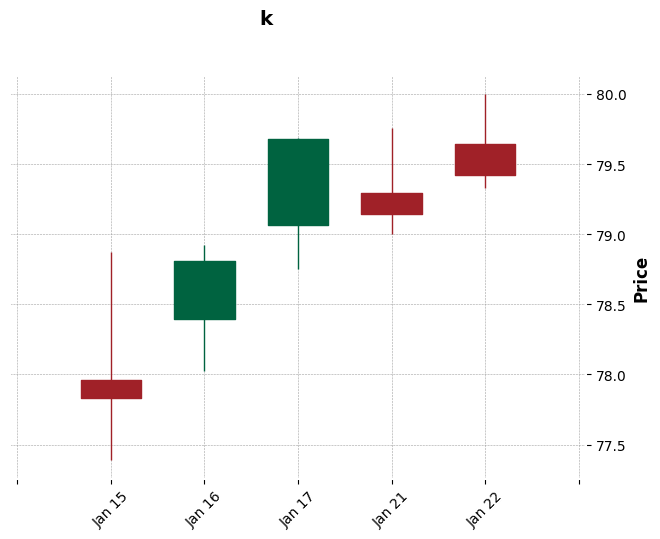

<Figure size 1000x500 with 0 Axes>

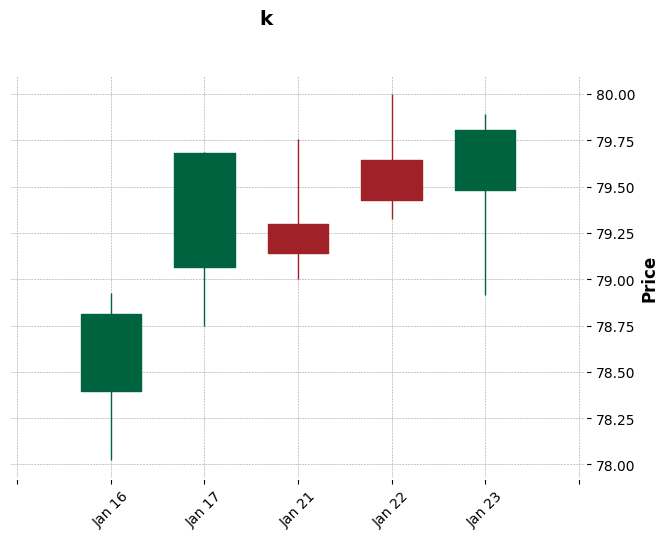

<Figure size 1000x500 with 0 Axes>

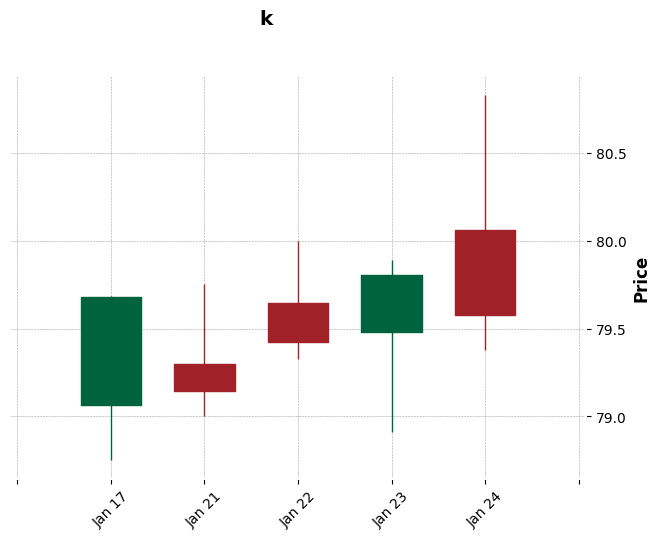

<Figure size 1000x500 with 0 Axes>

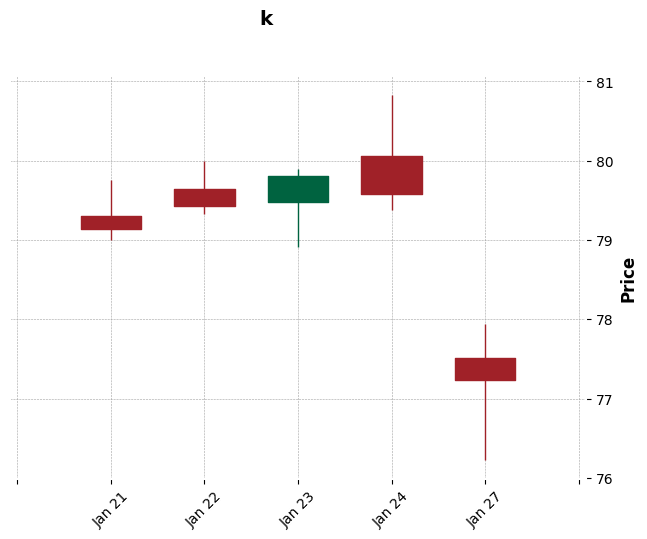

<Figure size 1000x500 with 0 Axes>

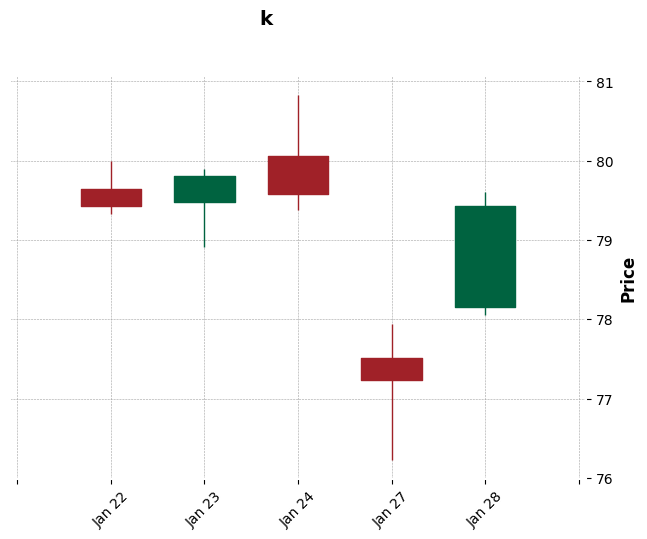

<Figure size 1000x500 with 0 Axes>

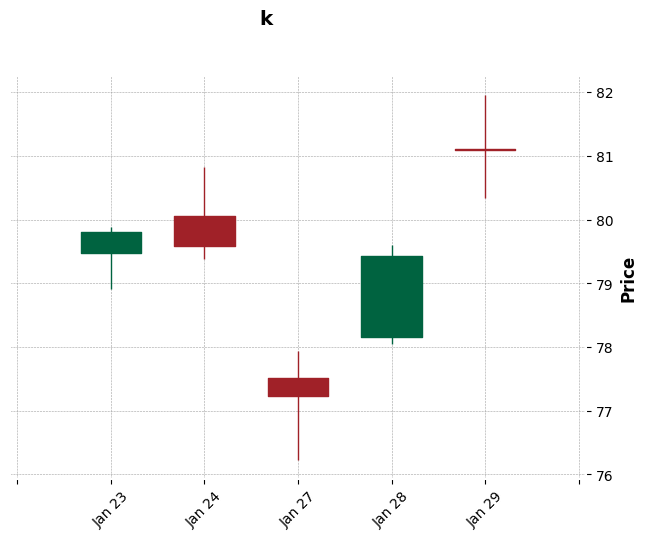

<Figure size 1000x500 with 0 Axes>

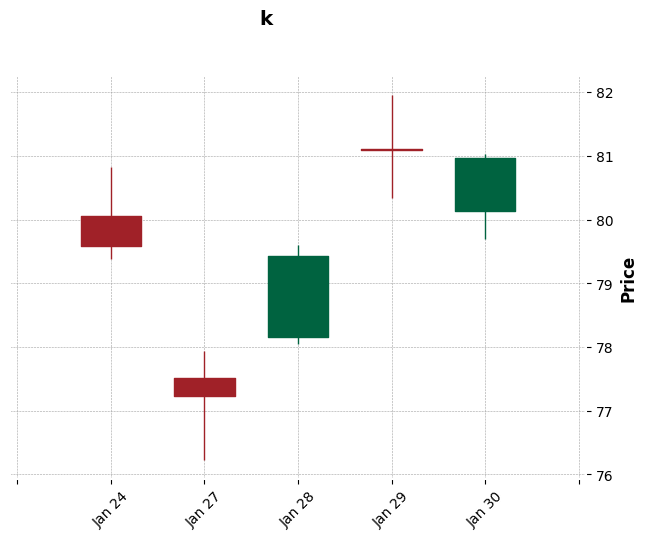

<Figure size 1000x500 with 0 Axes>

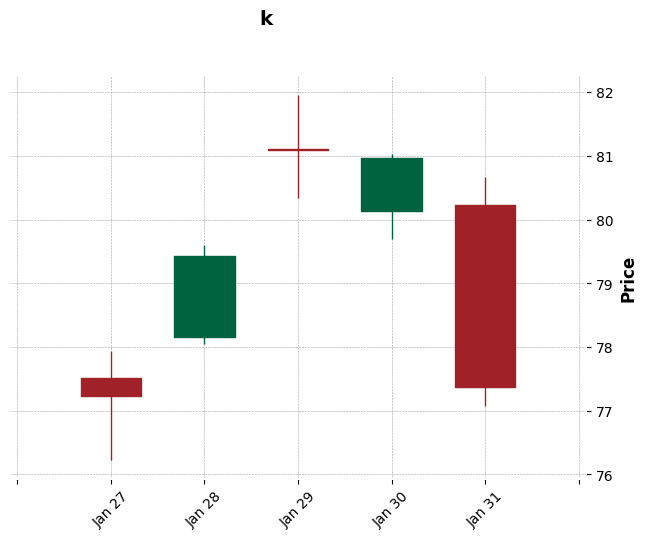

<Figure size 1000x500 with 0 Axes>

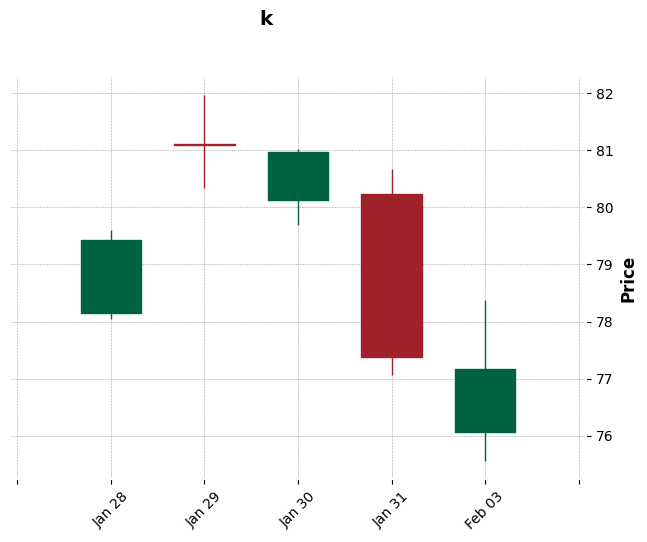

<Figure size 1000x500 with 0 Axes>

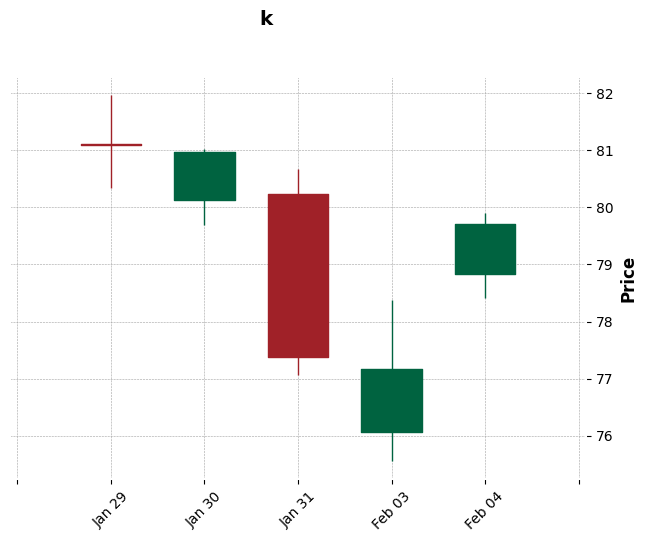

<Figure size 1000x500 with 0 Axes>

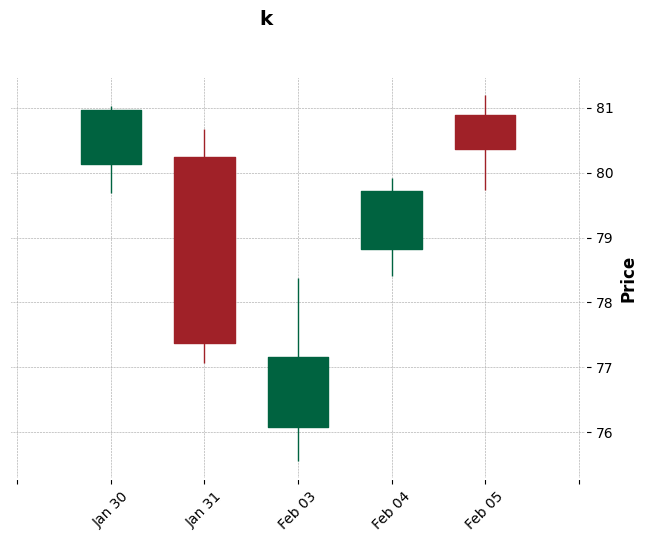

<Figure size 1000x500 with 0 Axes>

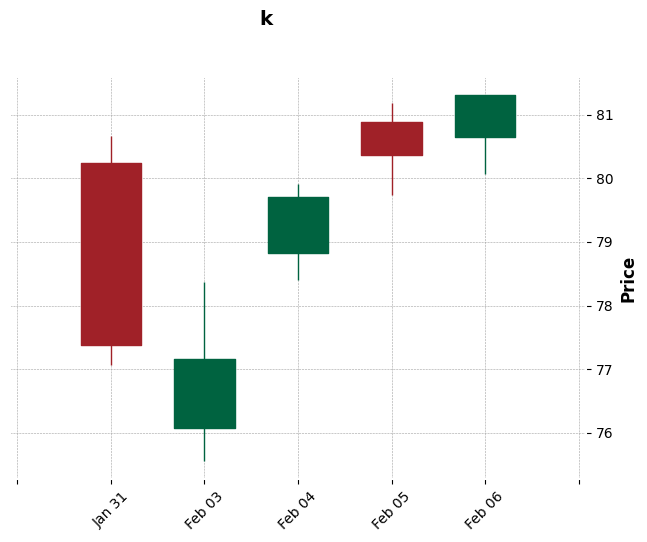

<Figure size 1000x500 with 0 Axes>

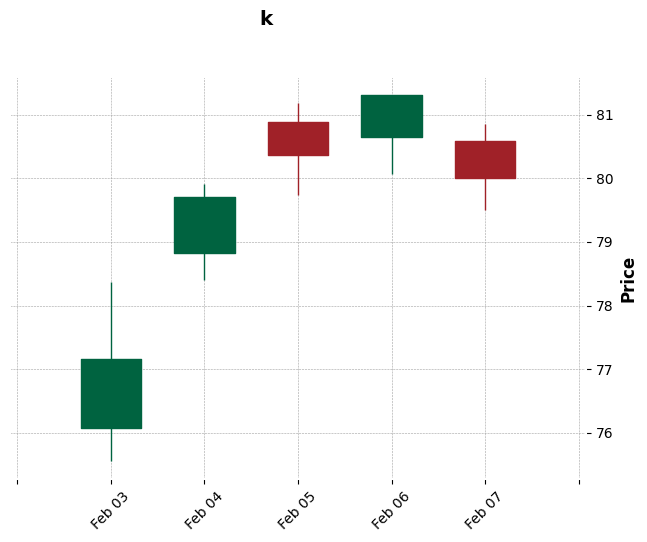

<Figure size 1000x500 with 0 Axes>

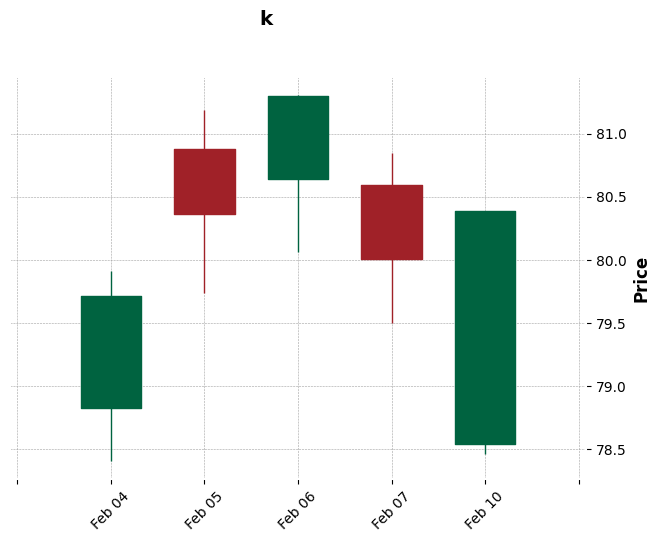

<Figure size 1000x500 with 0 Axes>

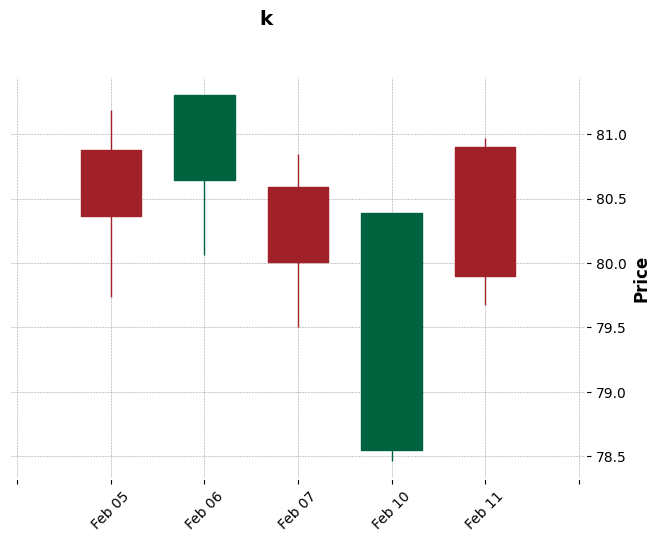

<Figure size 1000x500 with 0 Axes>

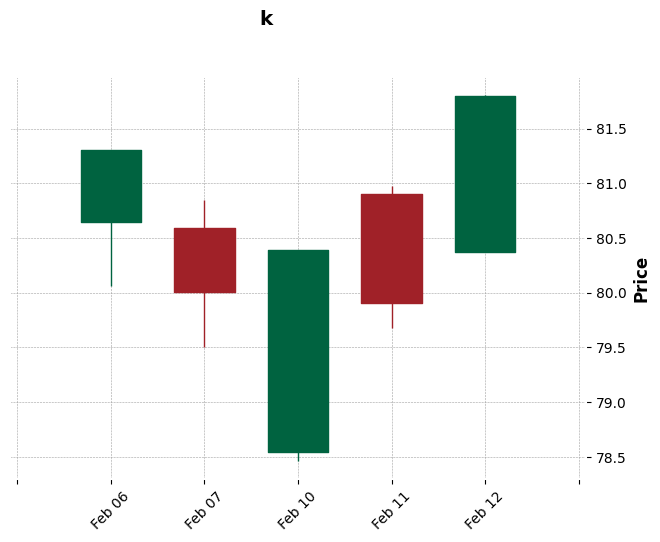

<Figure size 1000x500 with 0 Axes>

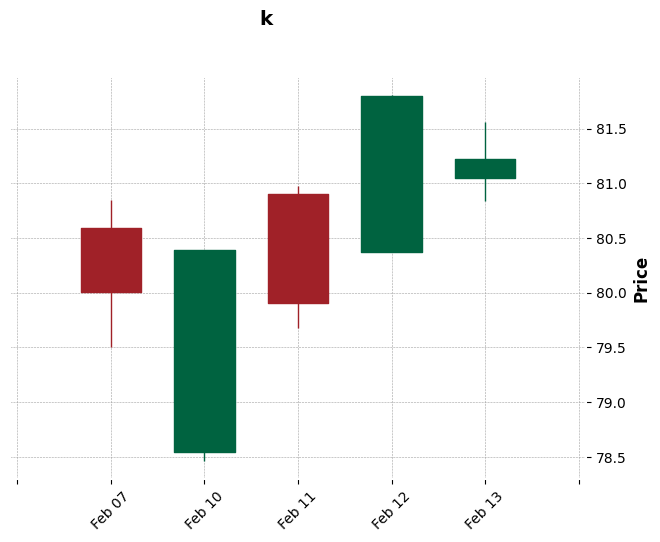

<Figure size 1000x500 with 0 Axes>

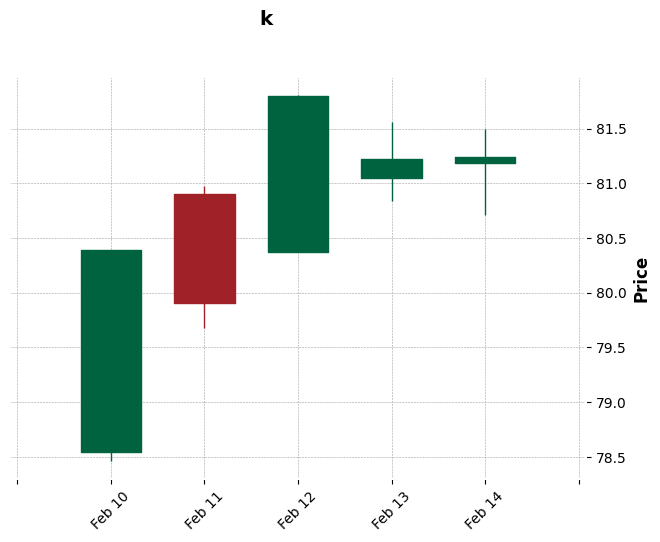

<Figure size 1000x500 with 0 Axes>

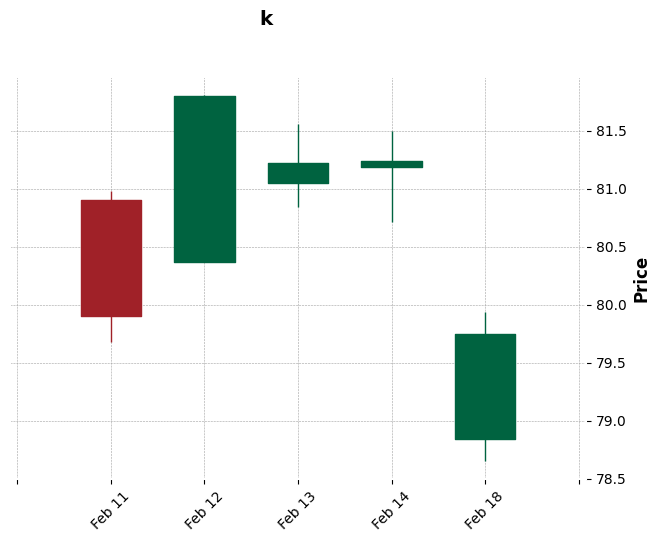

<Figure size 1000x500 with 0 Axes>

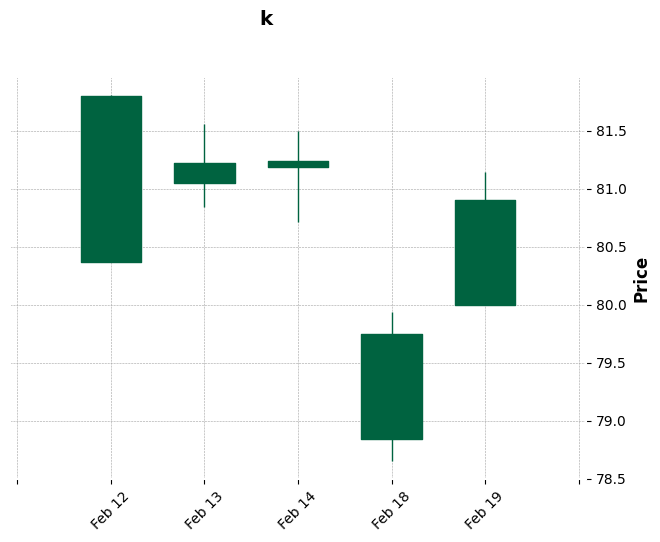

<Figure size 1000x500 with 0 Axes>

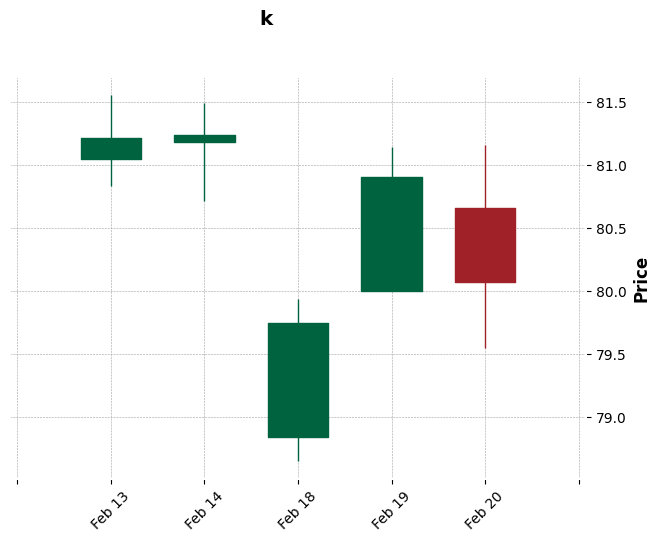

<Figure size 1000x500 with 0 Axes>

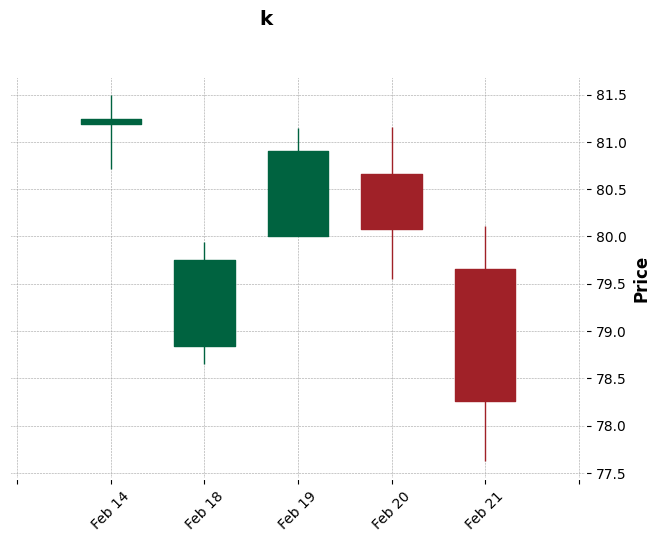

<Figure size 1000x500 with 0 Axes>

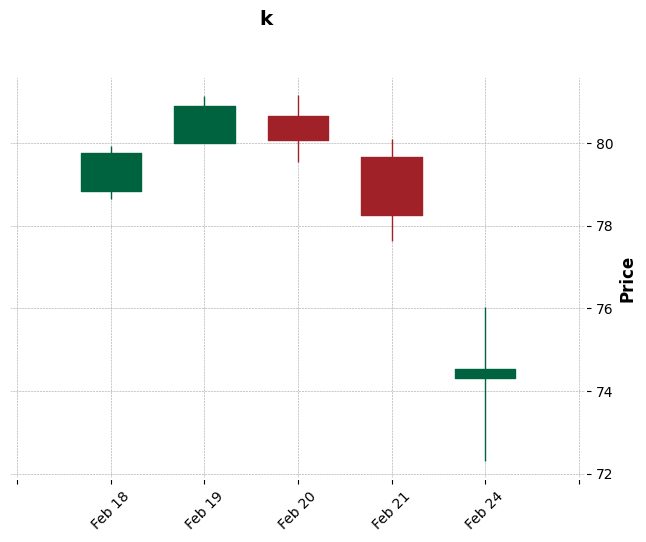

<Figure size 1000x500 with 0 Axes>

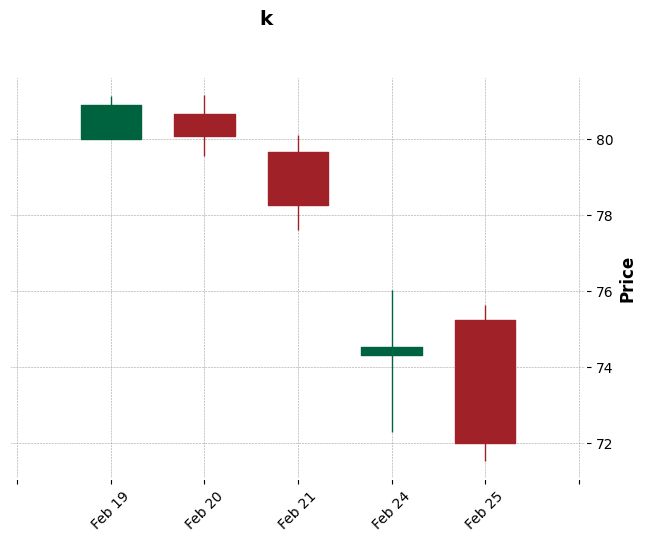

<Figure size 1000x500 with 0 Axes>

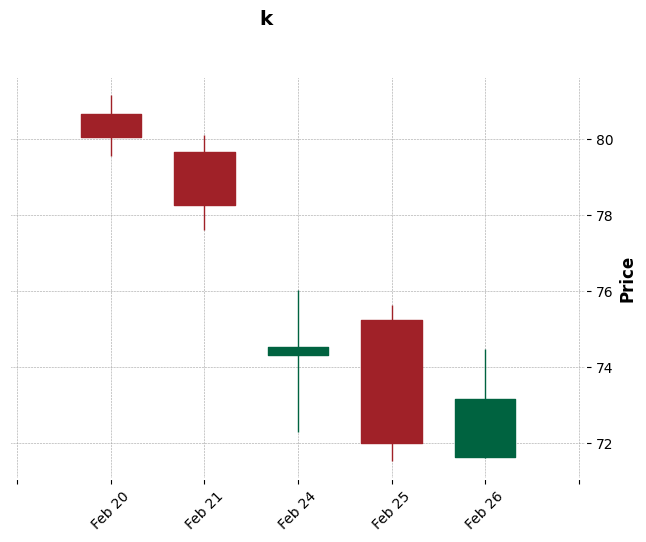

<Figure size 1000x500 with 0 Axes>

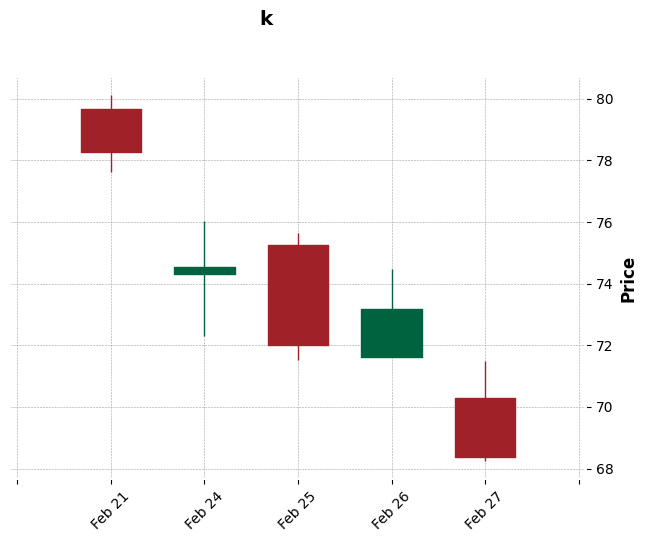

<Figure size 1000x500 with 0 Axes>

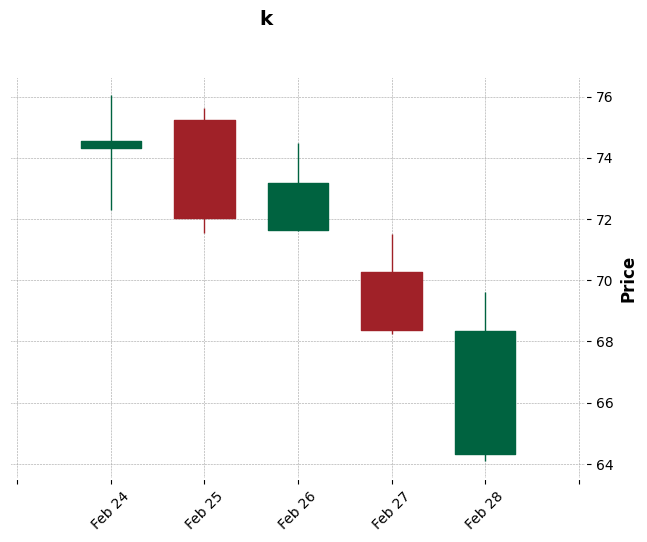

<Figure size 1000x500 with 0 Axes>

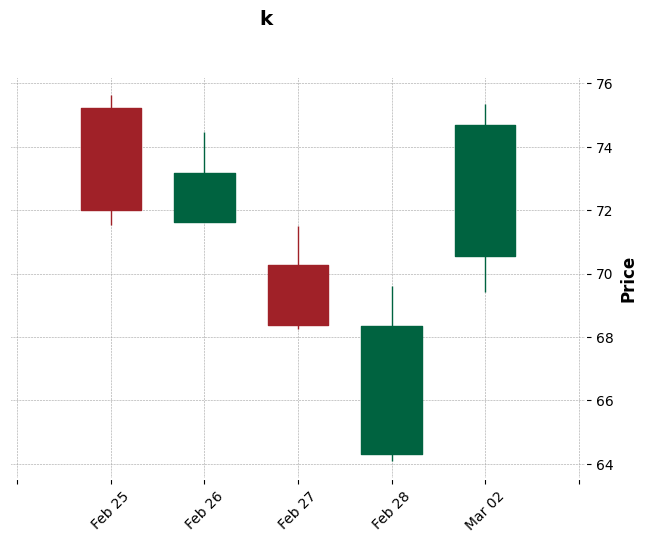

<Figure size 1000x500 with 0 Axes>

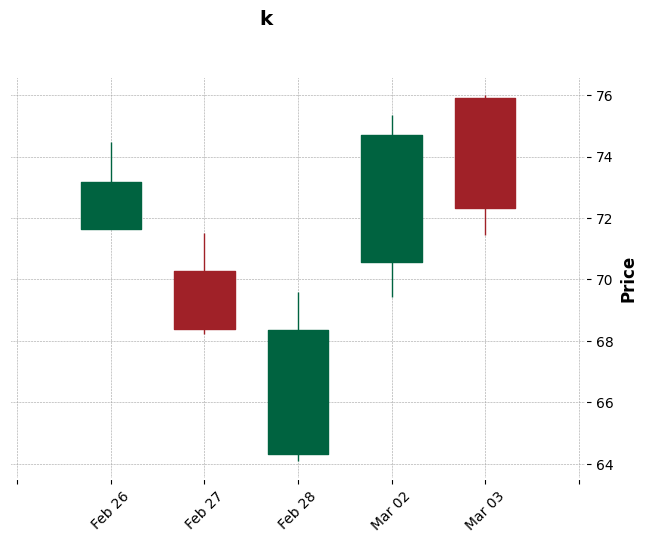

<Figure size 1000x500 with 0 Axes>

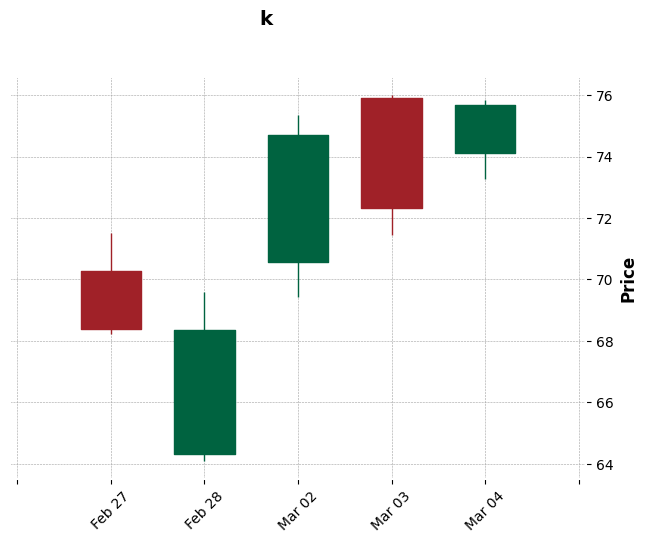

<Figure size 1000x500 with 0 Axes>

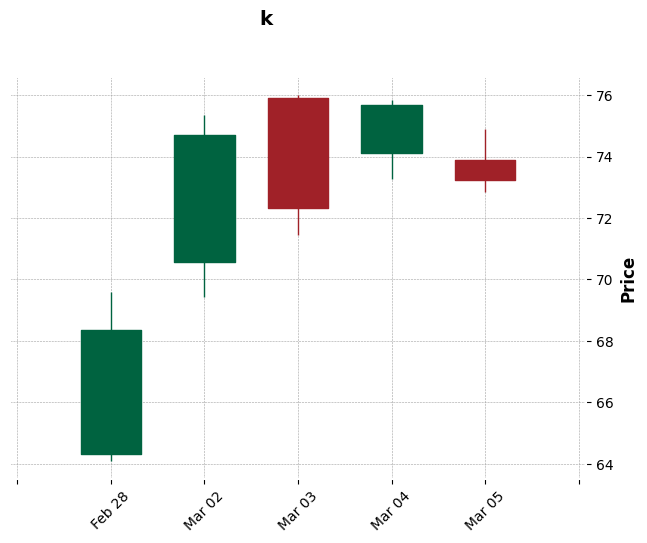

<Figure size 1000x500 with 0 Axes>

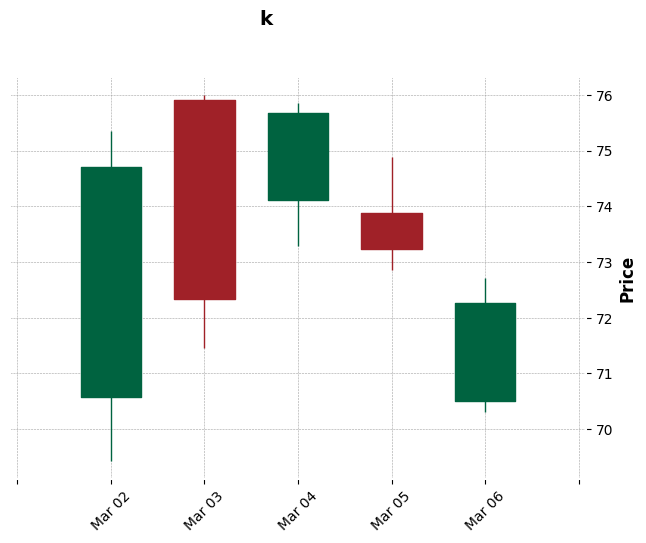

<Figure size 1000x500 with 0 Axes>

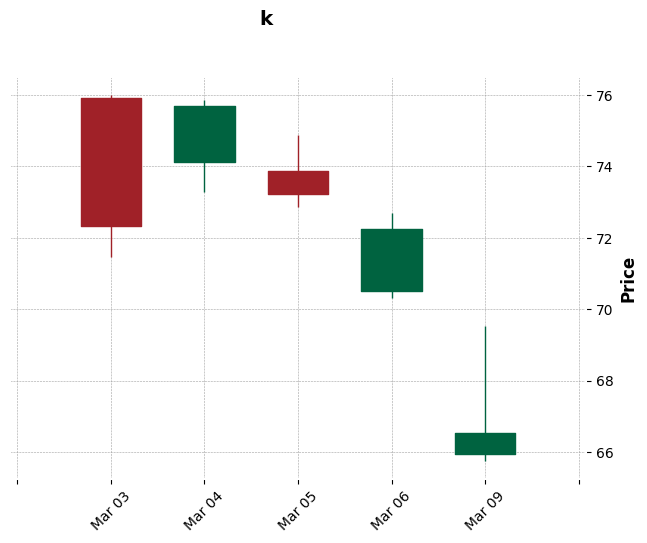

<Figure size 1000x500 with 0 Axes>

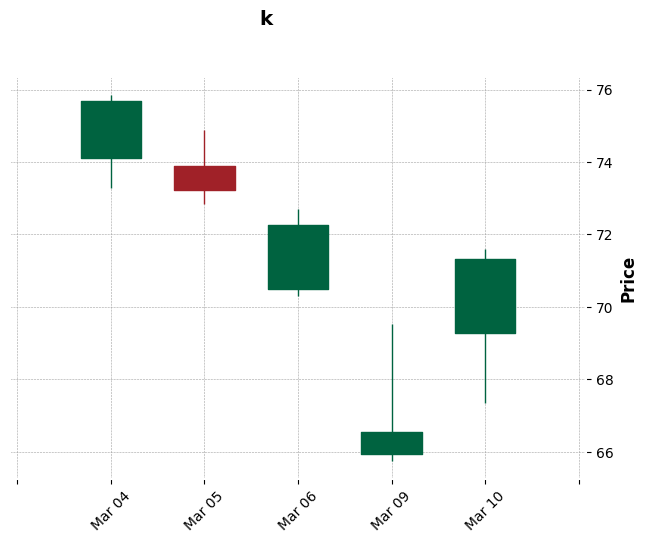

<Figure size 1000x500 with 0 Axes>

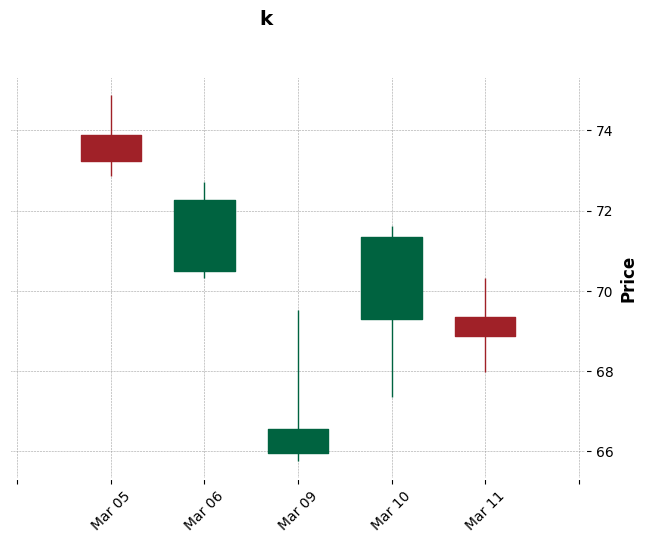

<Figure size 1000x500 with 0 Axes>

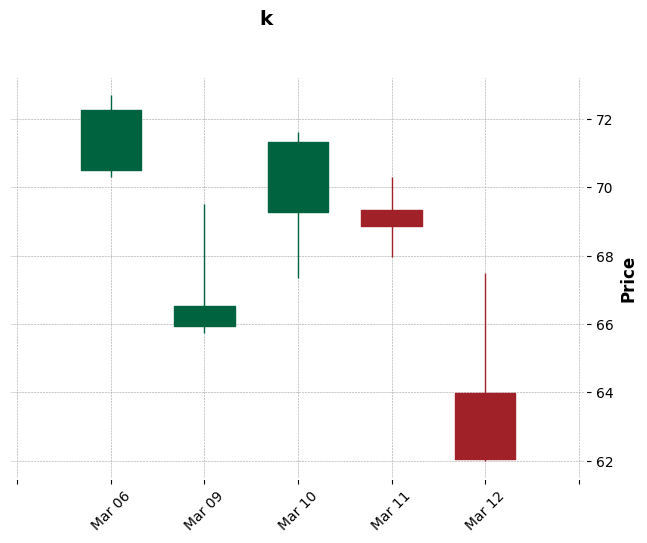

<Figure size 1000x500 with 0 Axes>

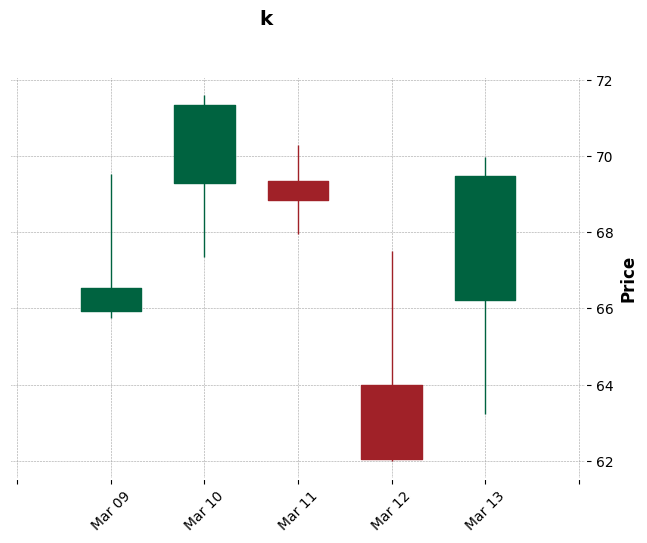

<Figure size 1000x500 with 0 Axes>

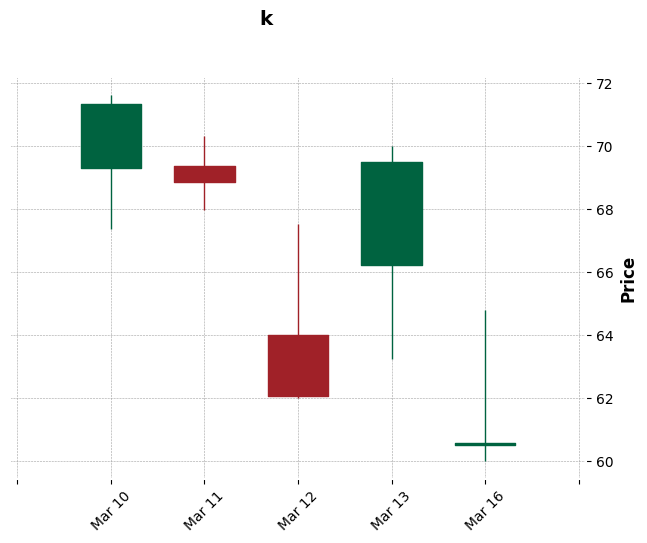

<Figure size 1000x500 with 0 Axes>

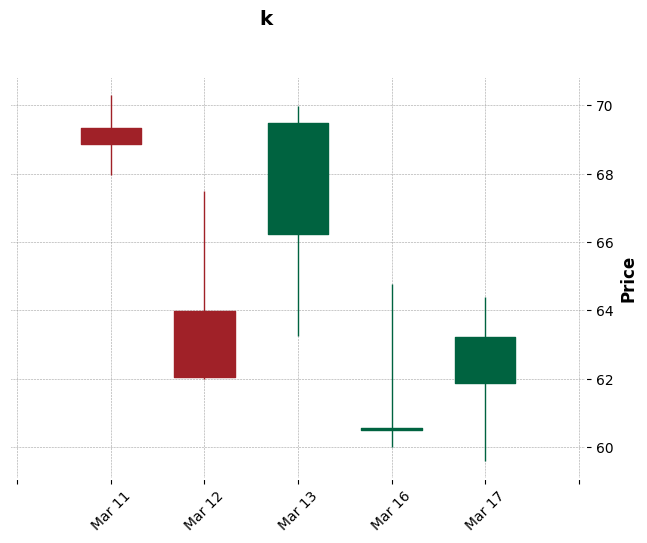

<Figure size 1000x500 with 0 Axes>

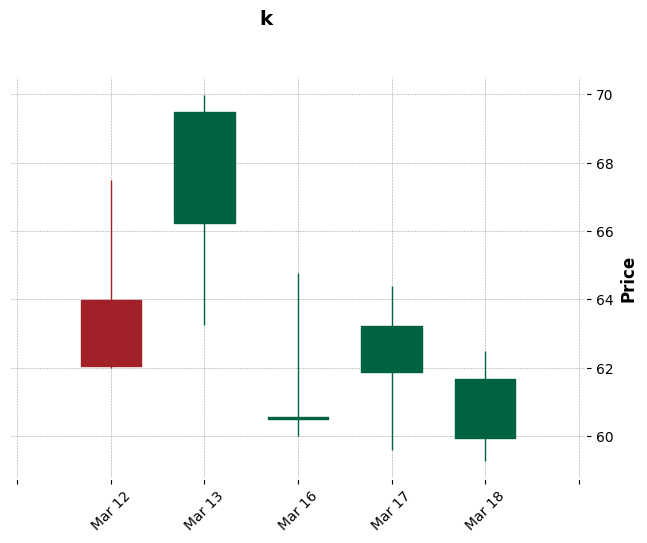

<Figure size 1000x500 with 0 Axes>

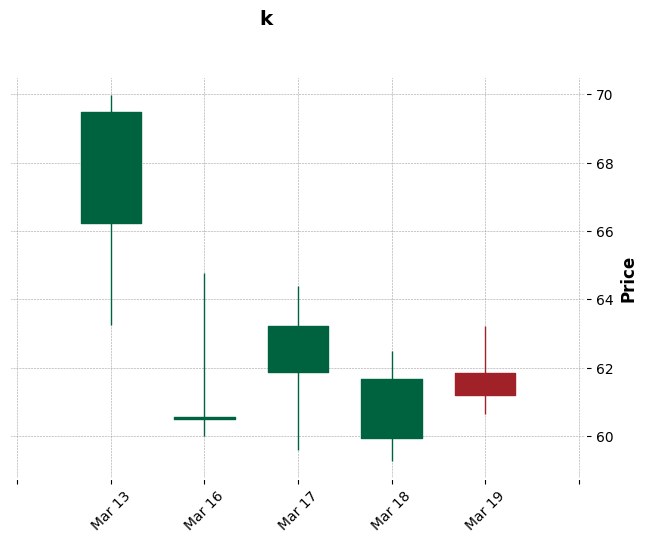

<Figure size 1000x500 with 0 Axes>

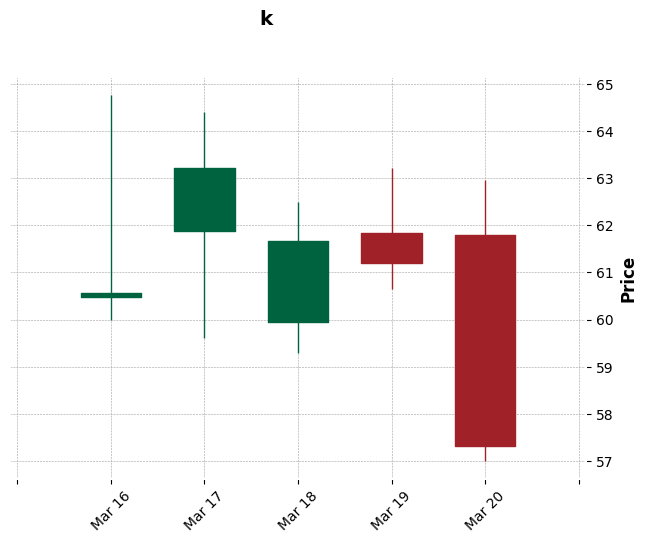

<Figure size 1000x500 with 0 Axes>

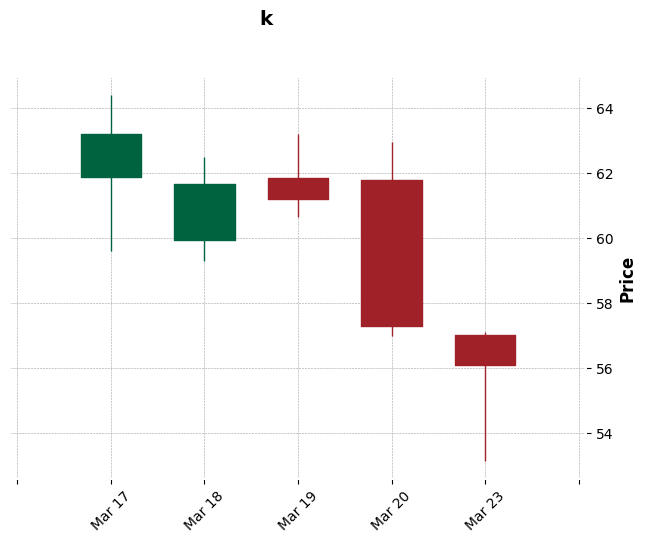

<Figure size 1000x500 with 0 Axes>

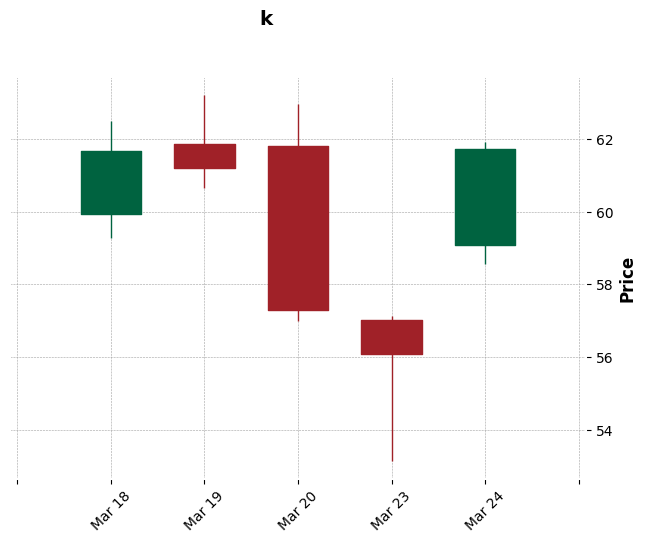

<Figure size 1000x500 with 0 Axes>

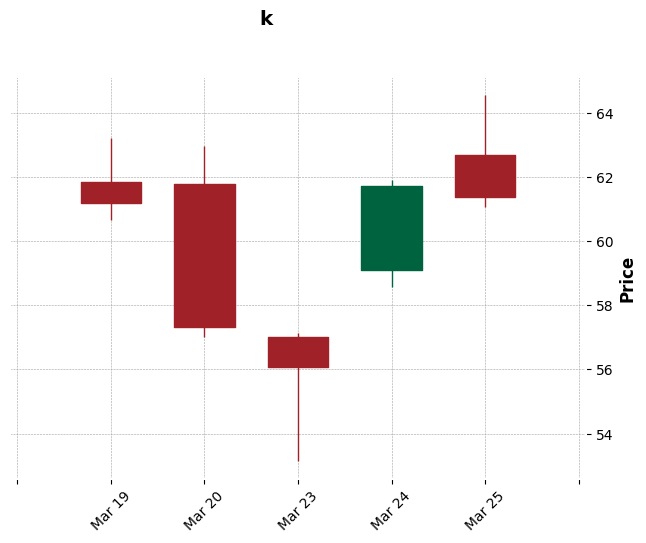

<Figure size 1000x500 with 0 Axes>

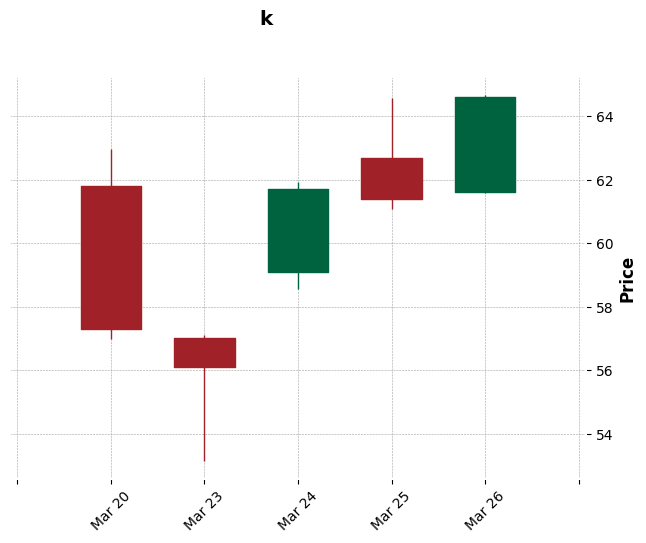

<Figure size 1000x500 with 0 Axes>

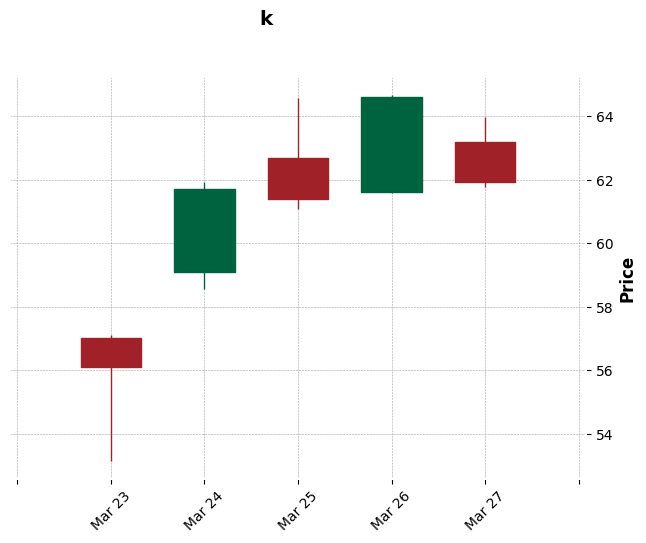

<Figure size 1000x500 with 0 Axes>

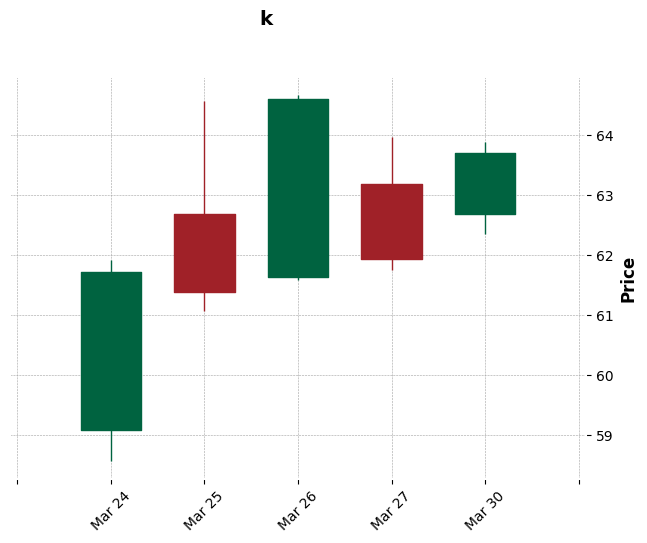

<Figure size 1000x500 with 0 Axes>

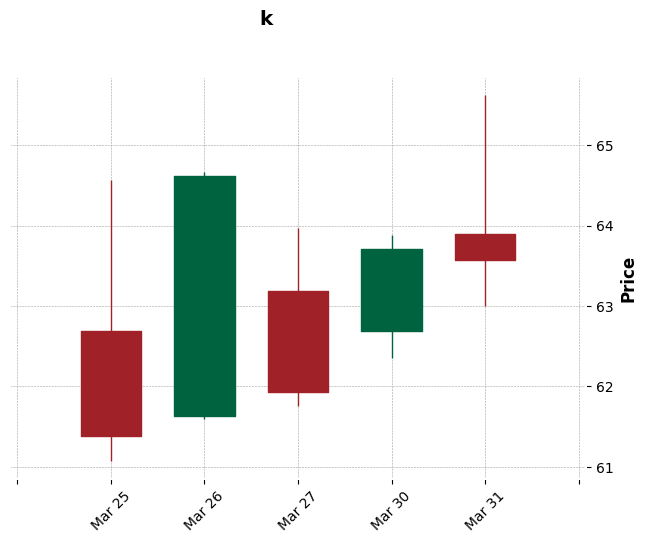

<Figure size 1000x500 with 0 Axes>

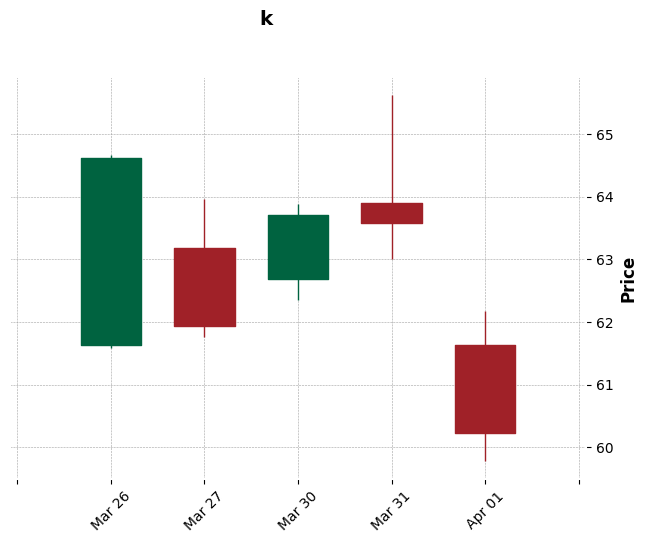

<Figure size 1000x500 with 0 Axes>

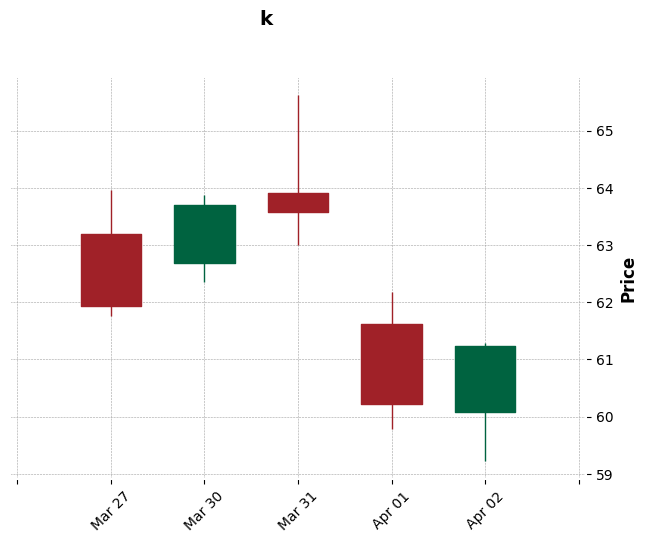

<Figure size 1000x500 with 0 Axes>

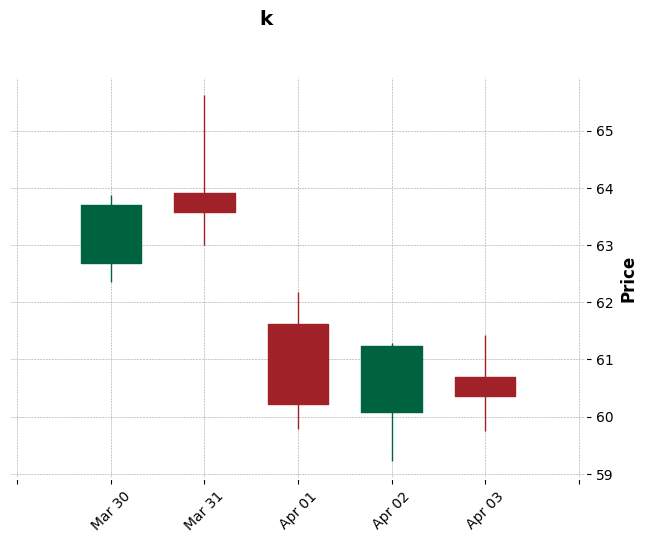

<Figure size 1000x500 with 0 Axes>

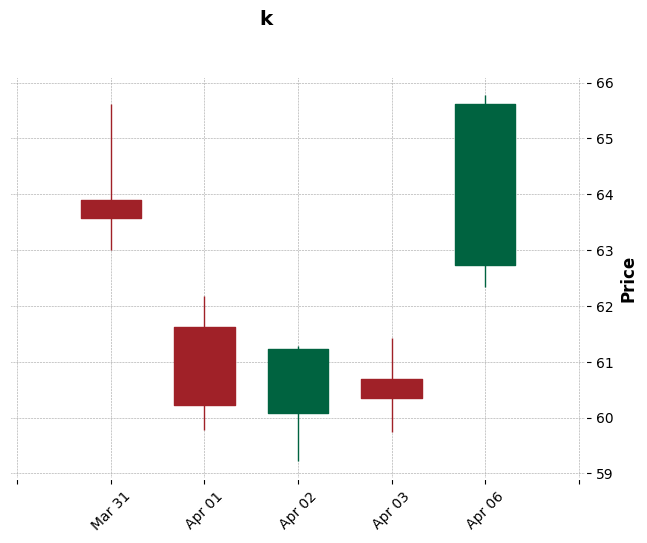

<Figure size 1000x500 with 0 Axes>

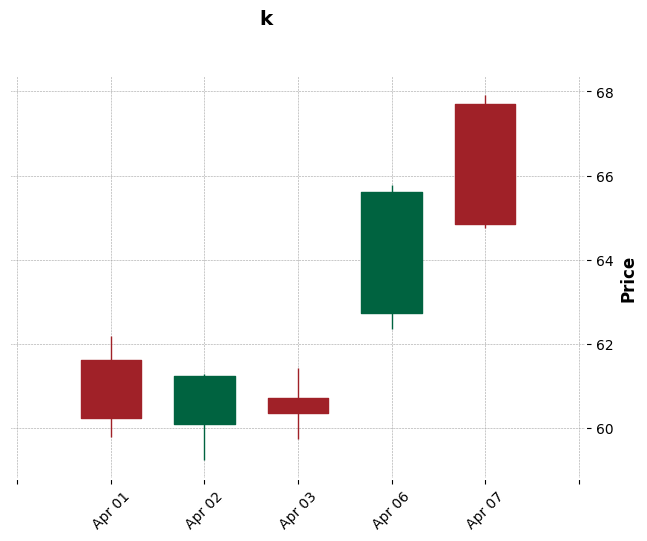

<Figure size 1000x500 with 0 Axes>

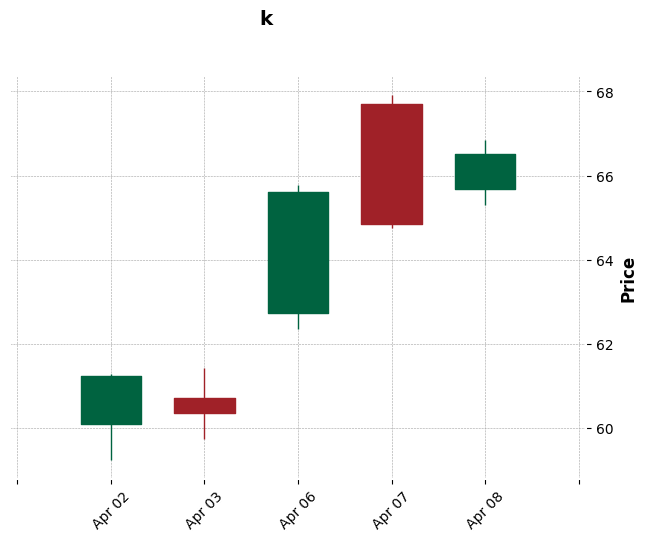

<Figure size 1000x500 with 0 Axes>

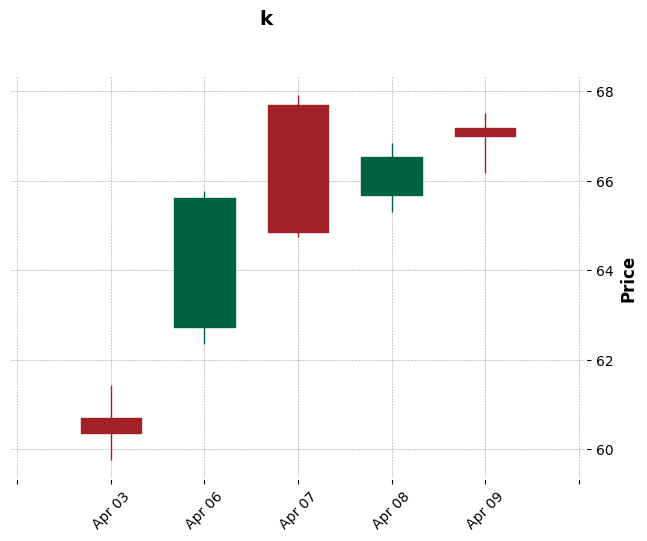

<Figure size 1000x500 with 0 Axes>

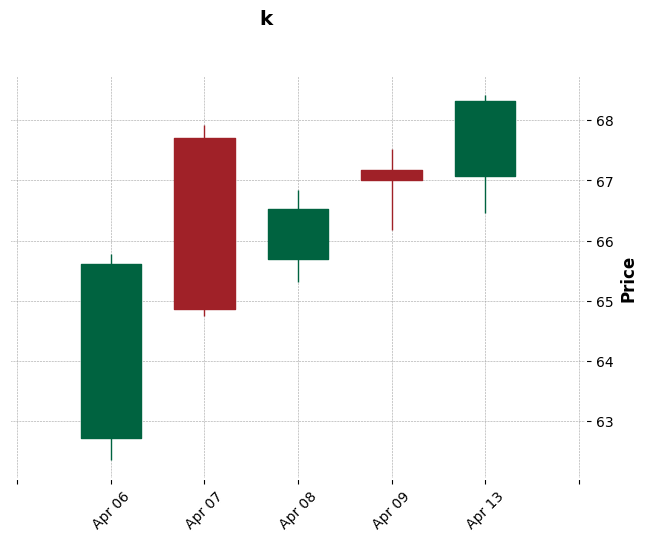

<Figure size 1000x500 with 0 Axes>

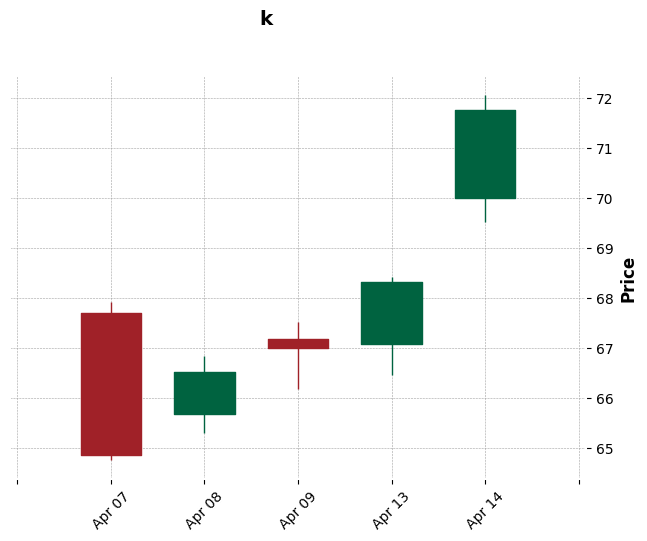

<Figure size 1000x500 with 0 Axes>

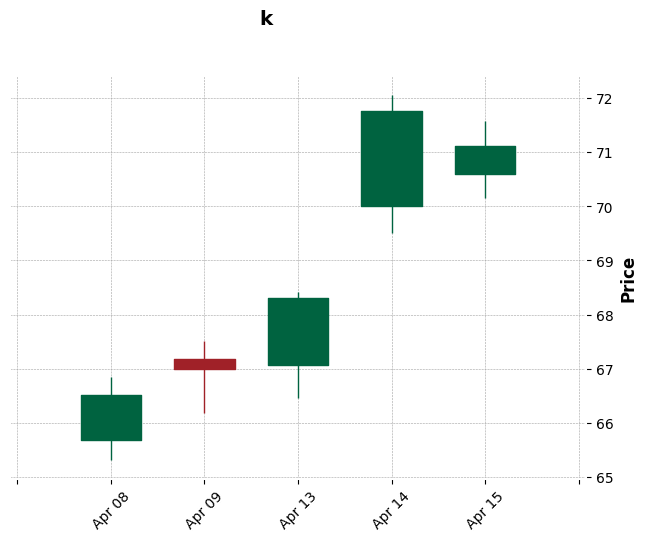

<Figure size 1000x500 with 0 Axes>

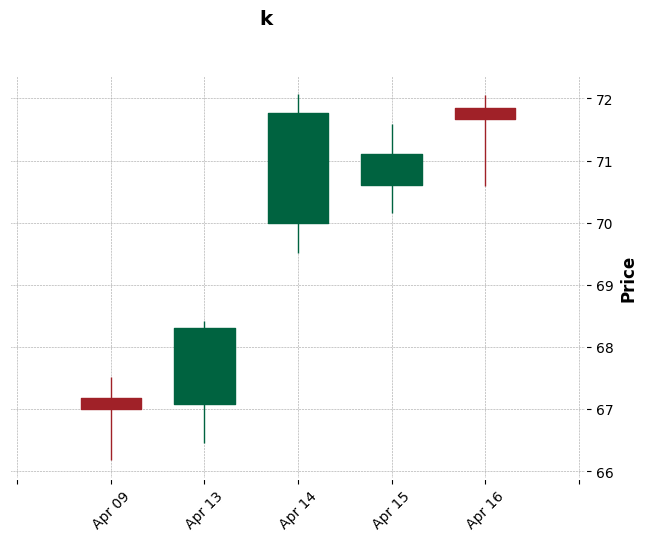

<Figure size 1000x500 with 0 Axes>

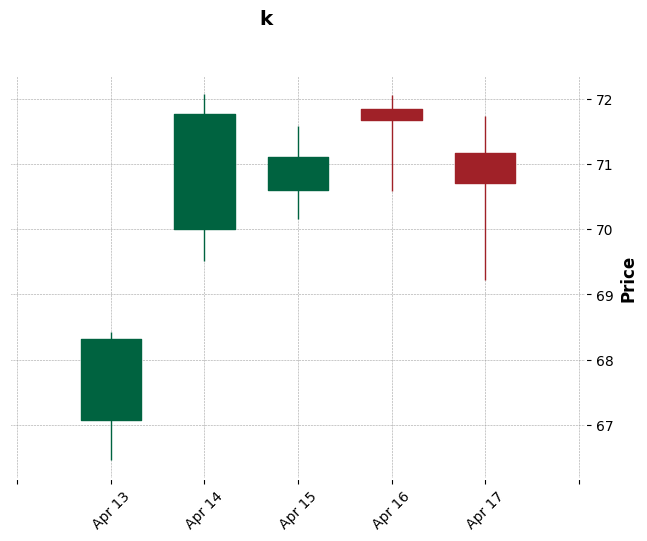

<Figure size 1000x500 with 0 Axes>

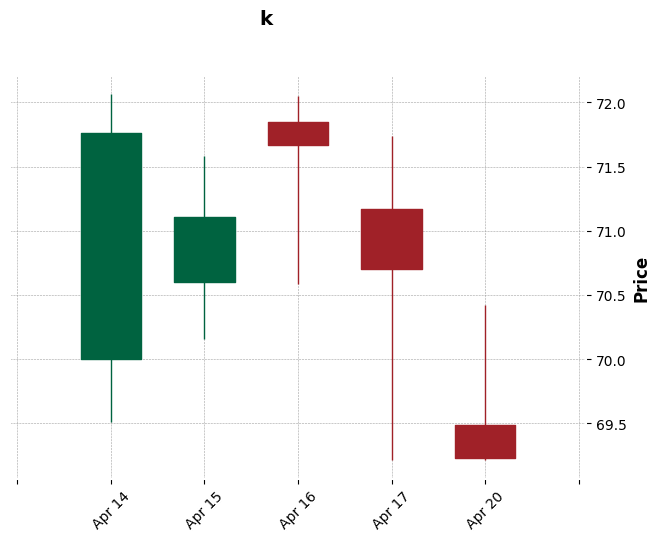

<Figure size 1000x500 with 0 Axes>

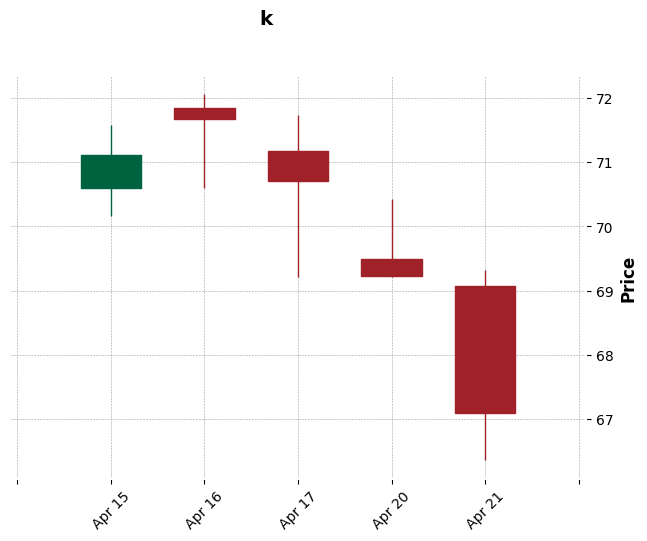

<Figure size 1000x500 with 0 Axes>

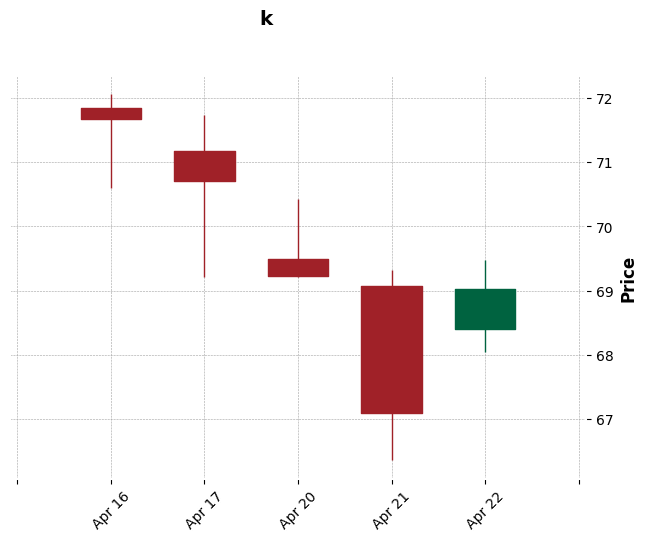

<Figure size 1000x500 with 0 Axes>

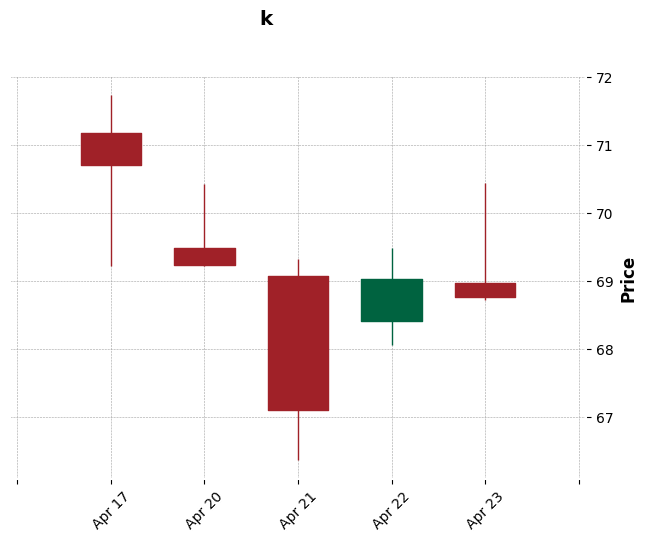

<Figure size 1000x500 with 0 Axes>

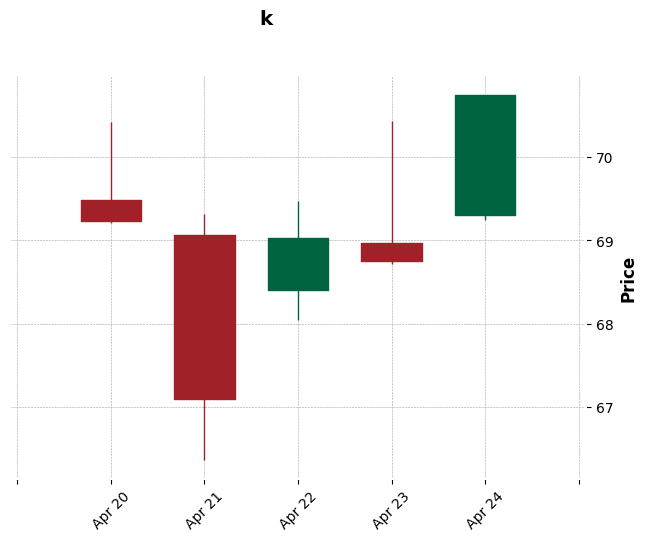

<Figure size 1000x500 with 0 Axes>

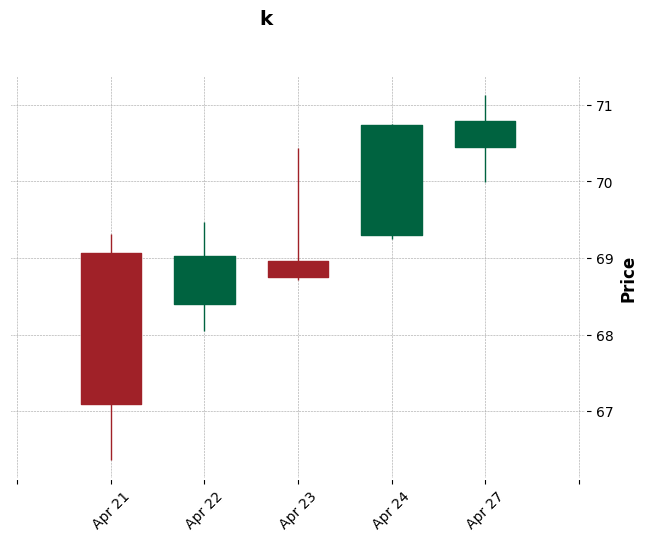

<Figure size 1000x500 with 0 Axes>

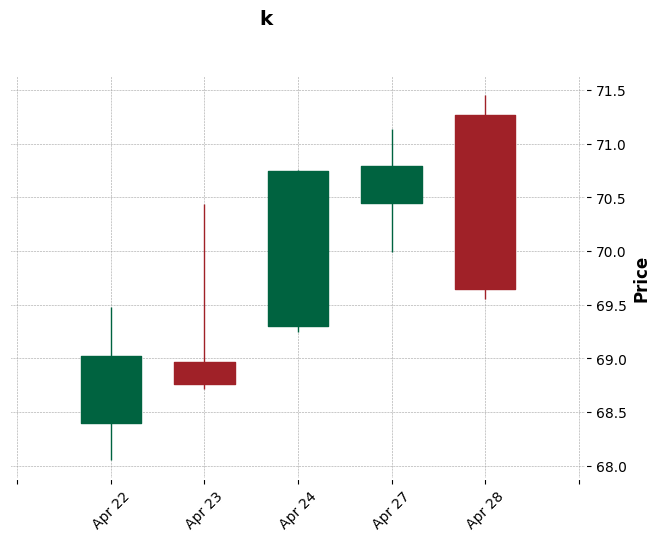

<Figure size 1000x500 with 0 Axes>

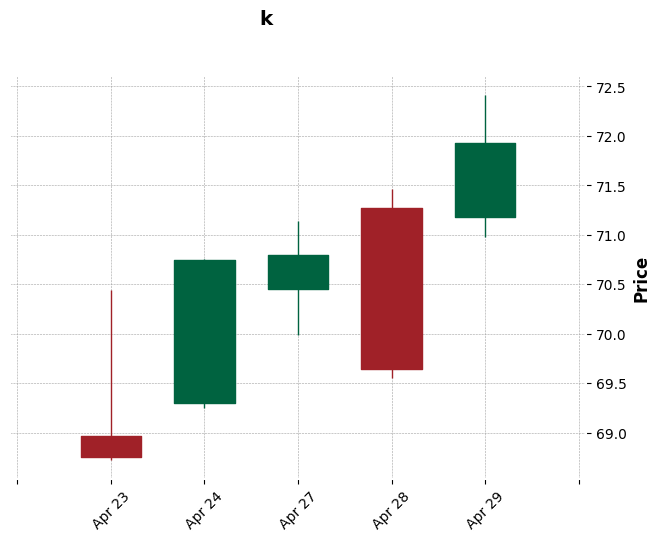

<Figure size 1000x500 with 0 Axes>

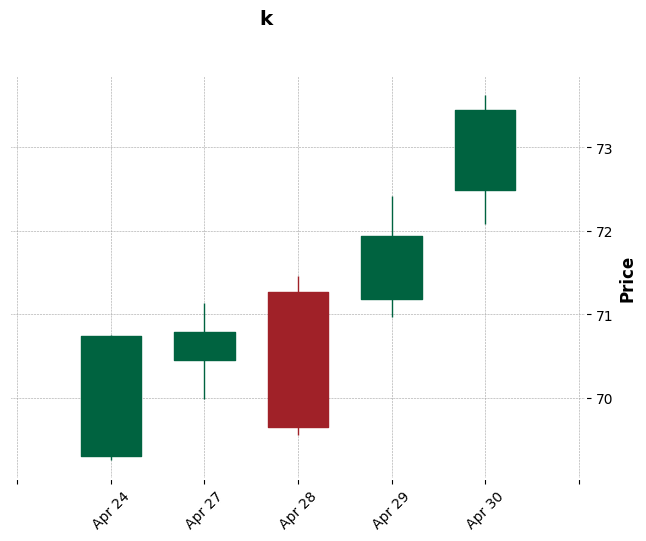

<Figure size 1000x500 with 0 Axes>

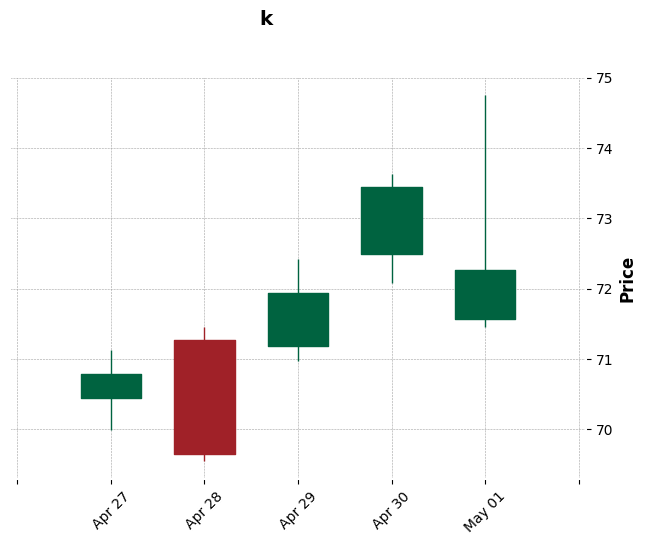

<Figure size 1000x500 with 0 Axes>

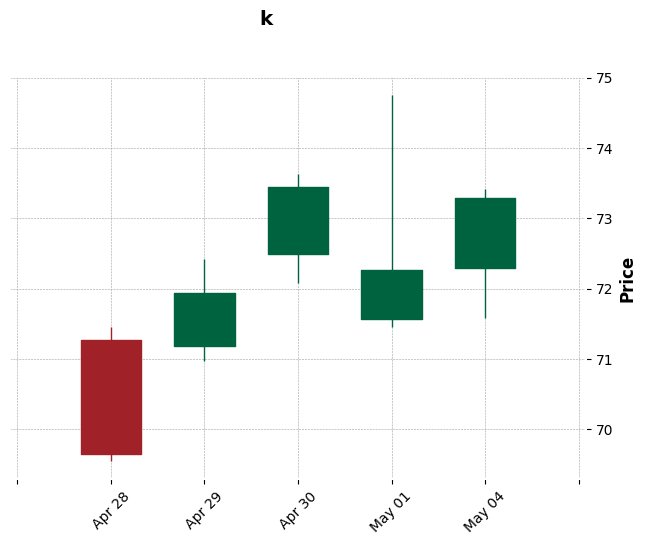

<Figure size 1000x500 with 0 Axes>

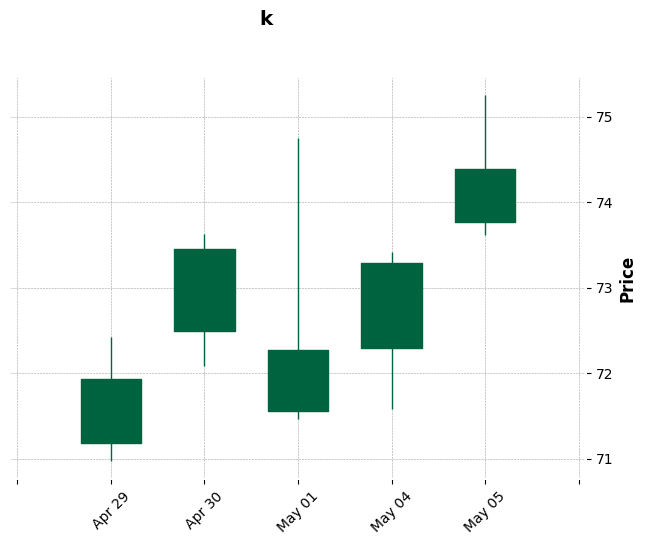

<Figure size 1000x500 with 0 Axes>

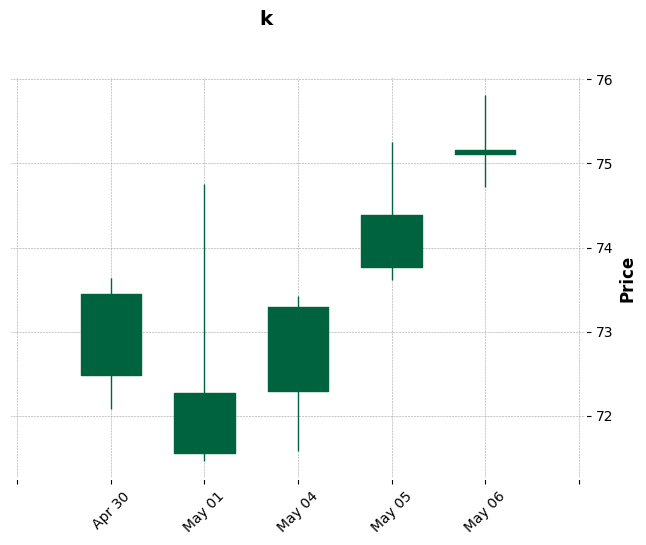

<Figure size 1000x500 with 0 Axes>

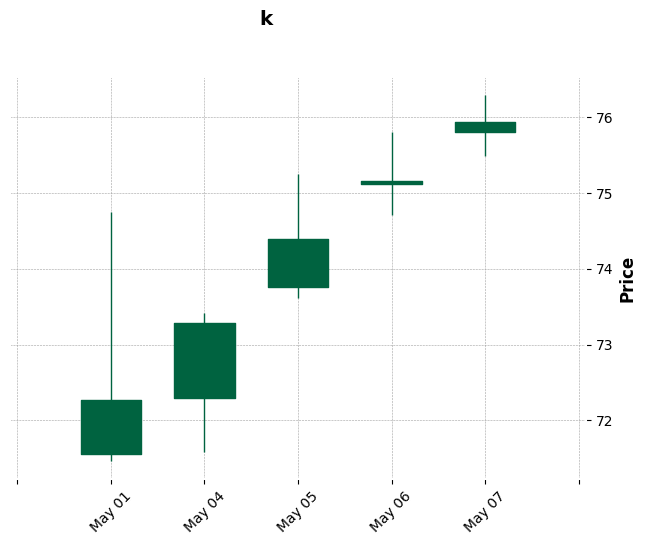

<Figure size 1000x500 with 0 Axes>

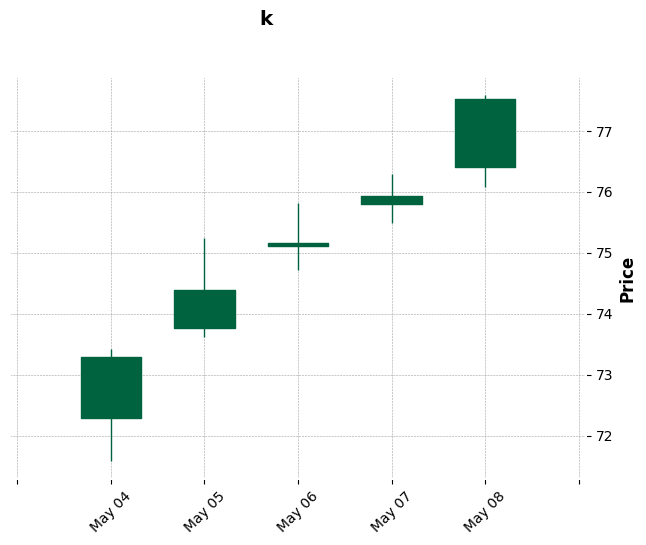

<Figure size 1000x500 with 0 Axes>

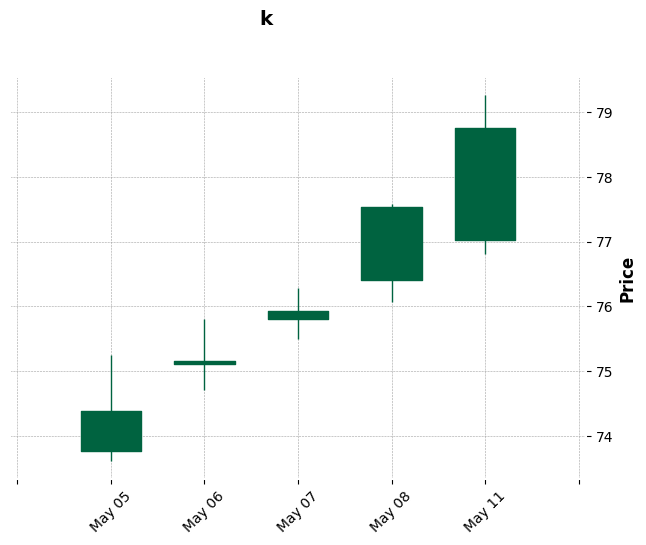

<Figure size 1000x500 with 0 Axes>

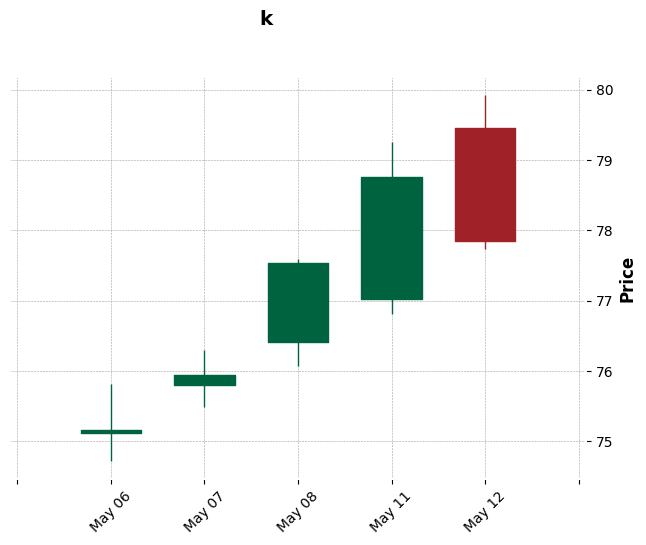

<Figure size 1000x500 with 0 Axes>

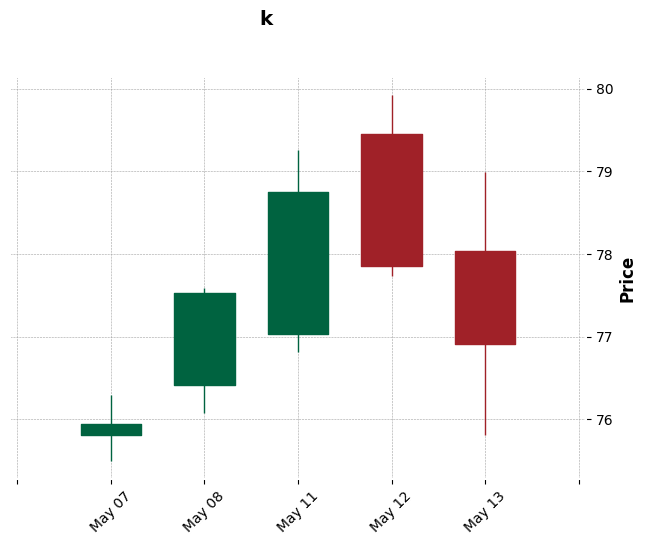

<Figure size 1000x500 with 0 Axes>

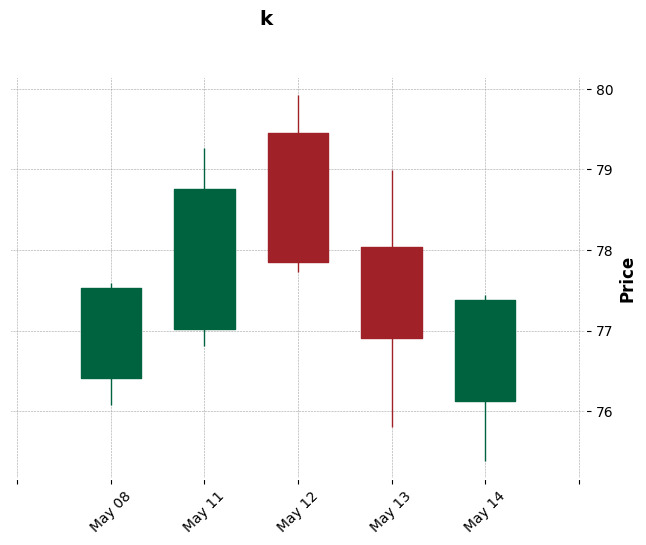

<Figure size 1000x500 with 0 Axes>

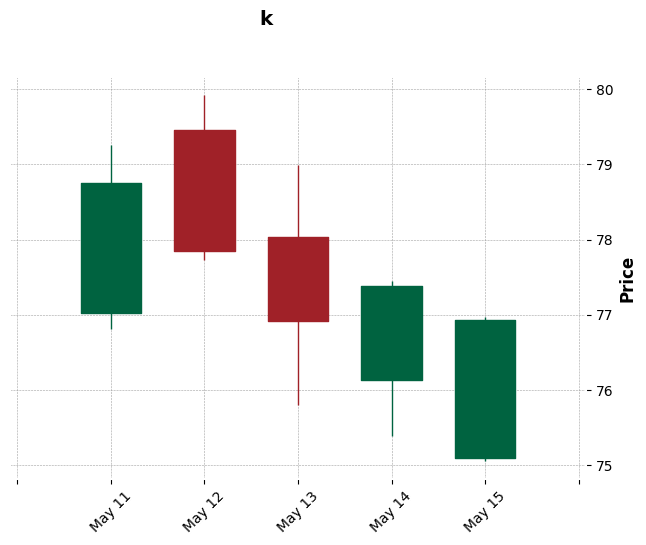

<Figure size 1000x500 with 0 Axes>

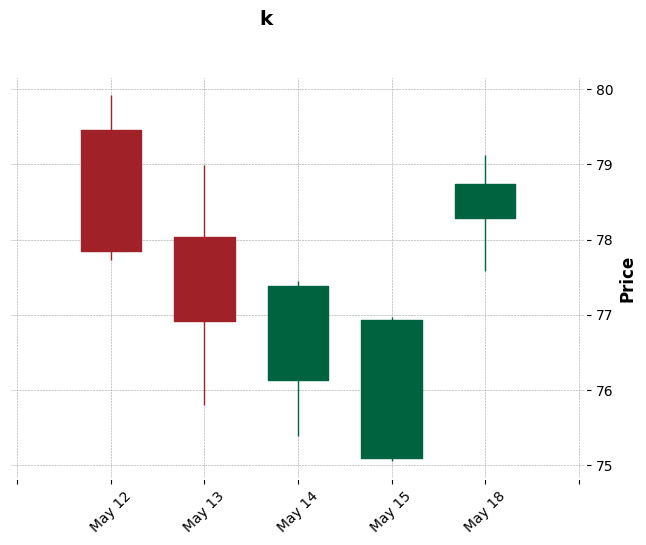

<Figure size 1000x500 with 0 Axes>

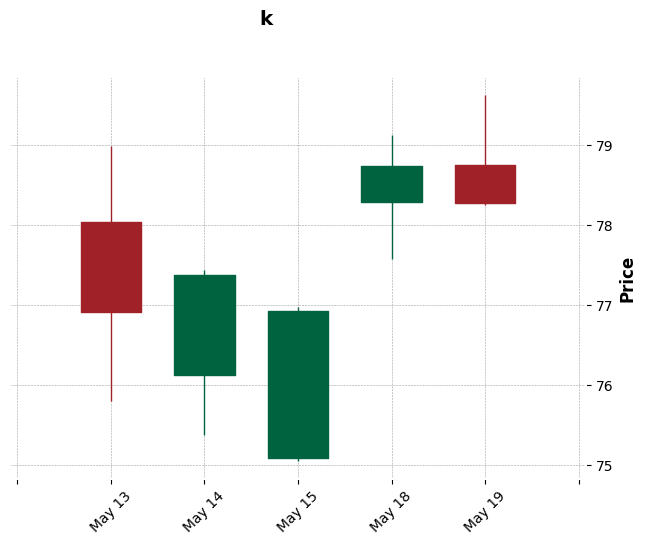

<Figure size 1000x500 with 0 Axes>

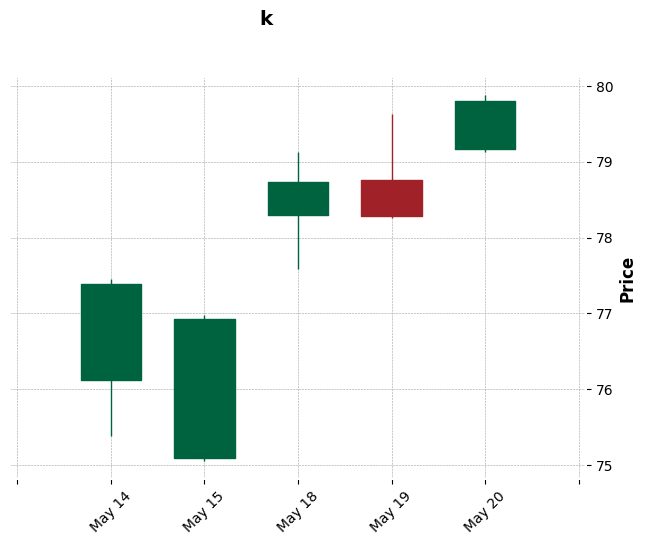

<Figure size 1000x500 with 0 Axes>

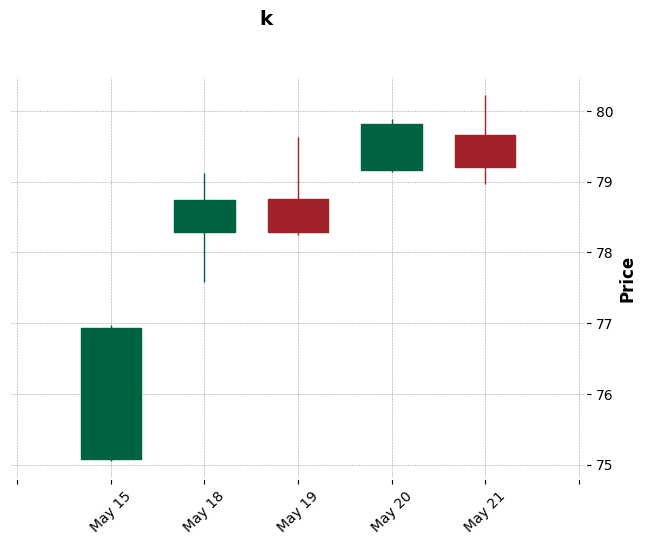

<Figure size 1000x500 with 0 Axes>

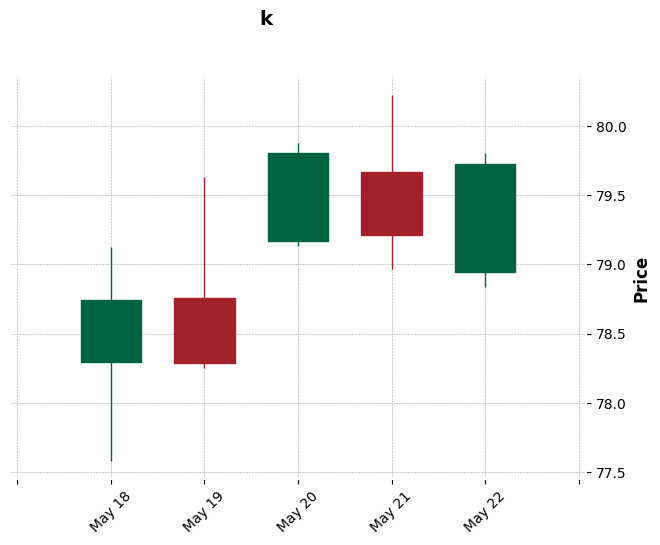

<Figure size 1000x500 with 0 Axes>

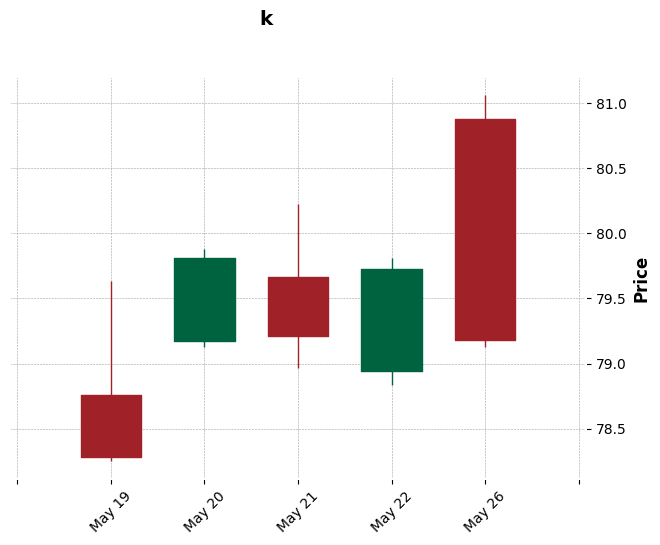

<Figure size 1000x500 with 0 Axes>

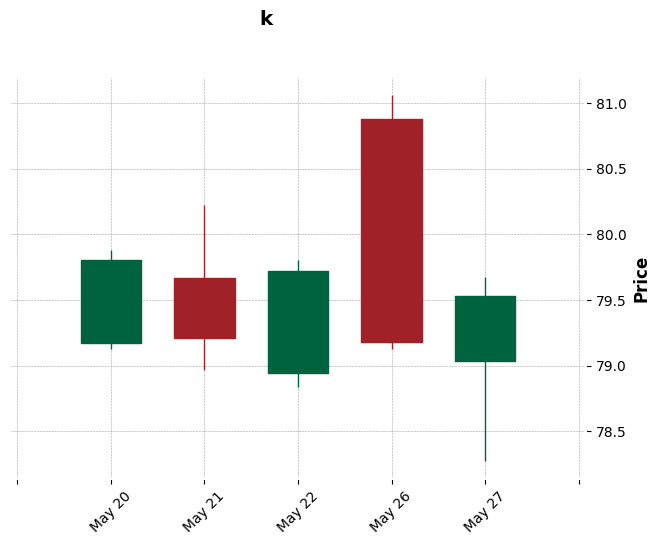

<Figure size 1000x500 with 0 Axes>

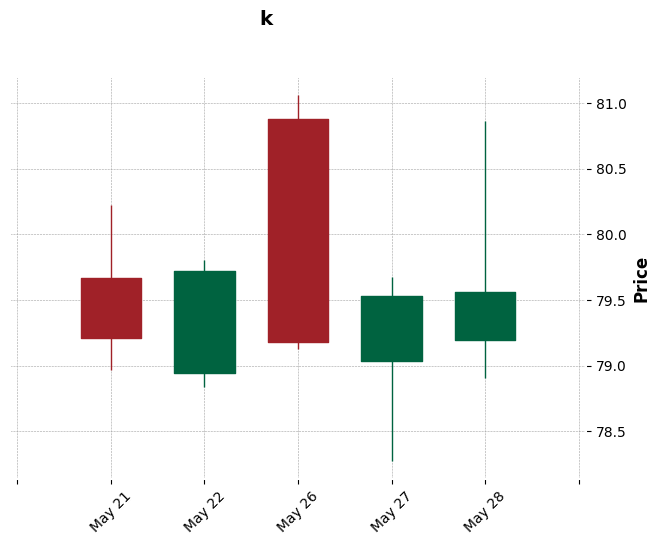

<Figure size 1000x500 with 0 Axes>

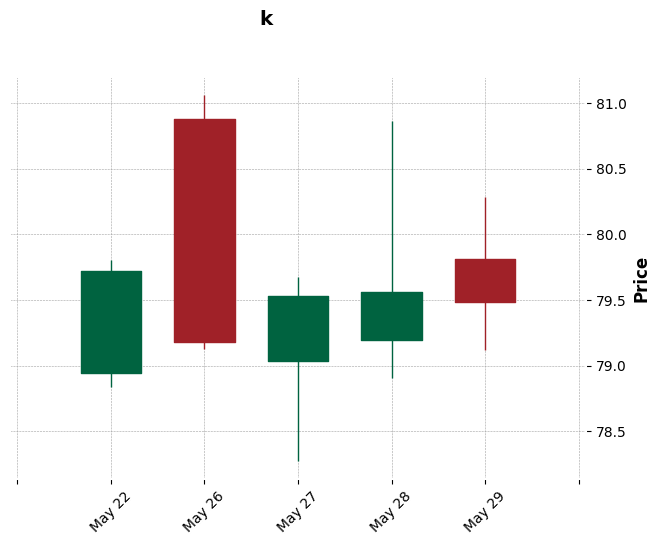

<Figure size 1000x500 with 0 Axes>

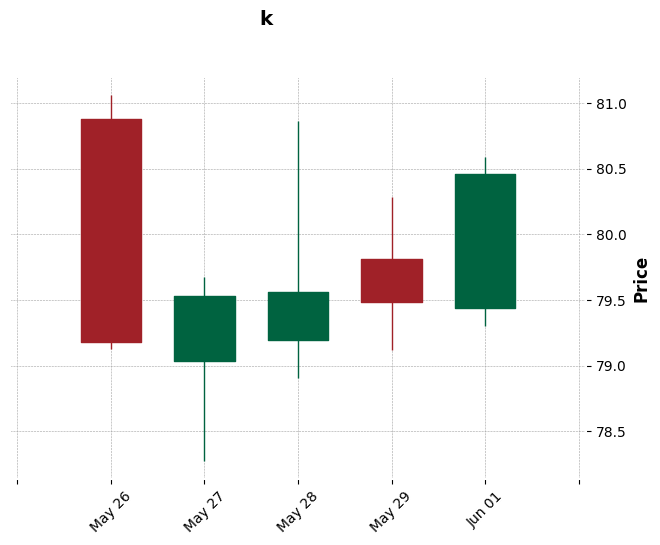

<Figure size 1000x500 with 0 Axes>

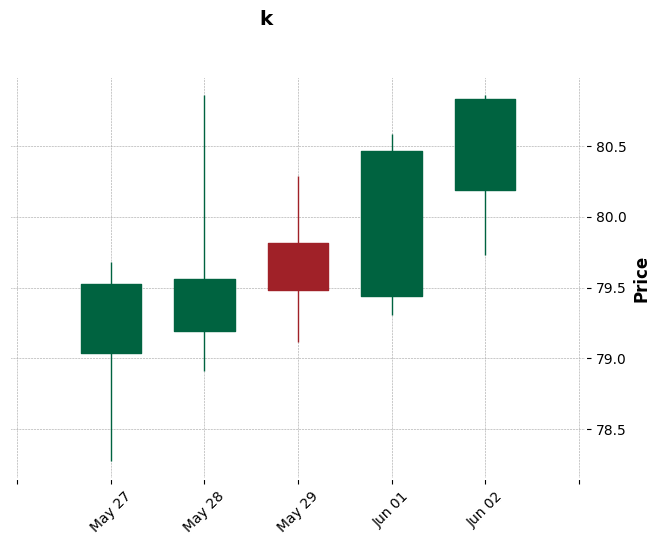

<Figure size 1000x500 with 0 Axes>

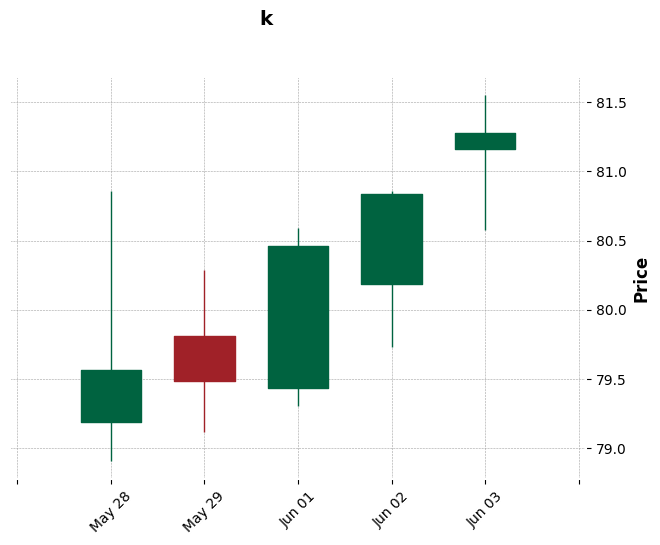

<Figure size 1000x500 with 0 Axes>

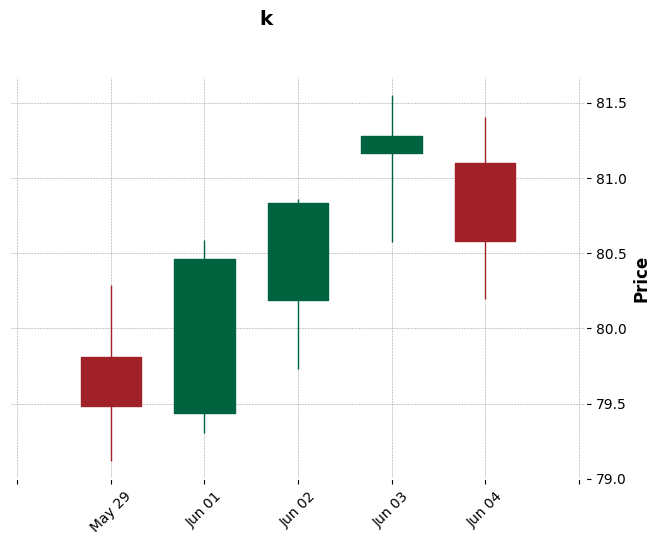

<Figure size 1000x500 with 0 Axes>

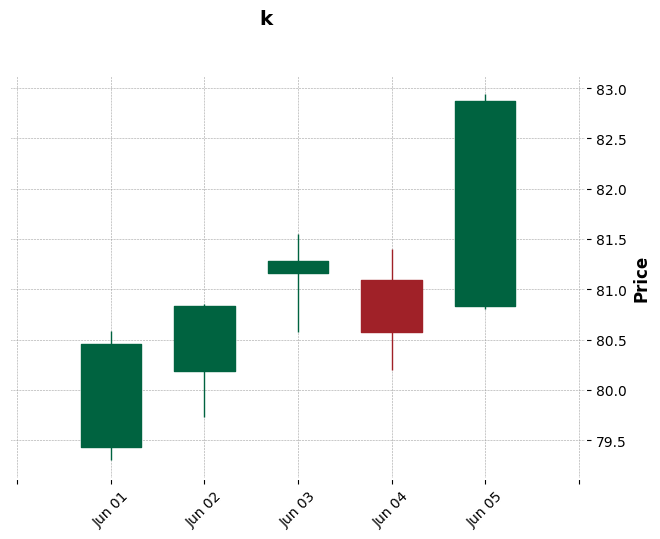

<Figure size 1000x500 with 0 Axes>

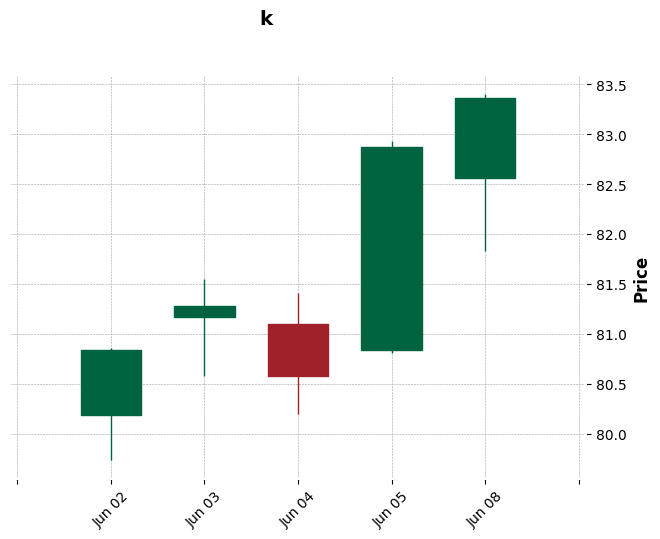

<Figure size 1000x500 with 0 Axes>

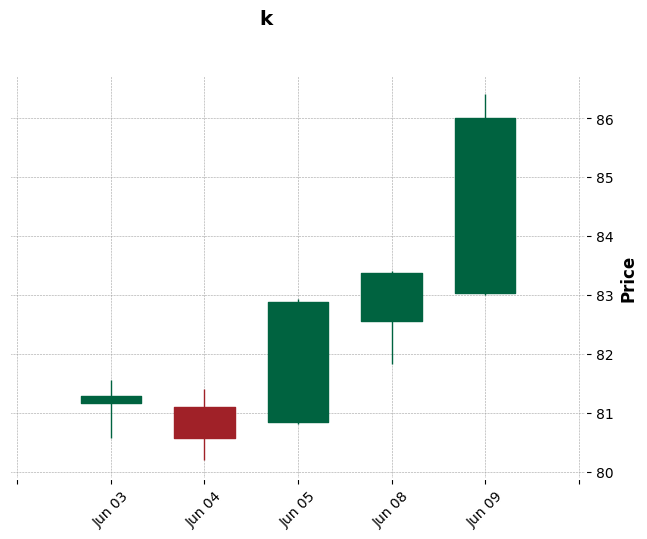

<Figure size 1000x500 with 0 Axes>

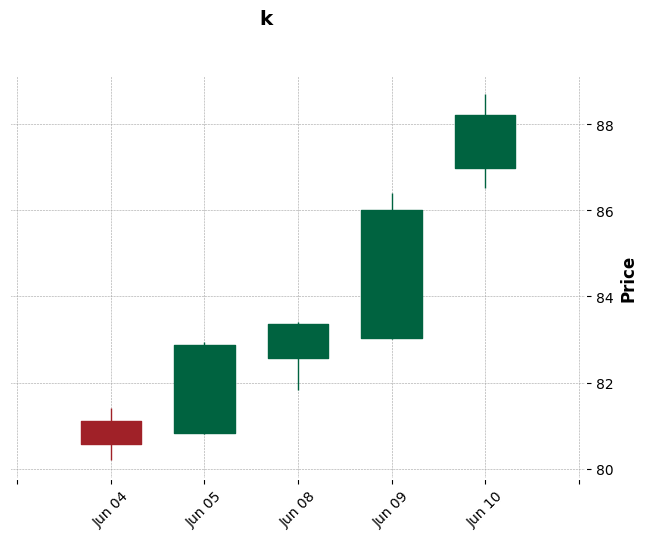

<Figure size 1000x500 with 0 Axes>

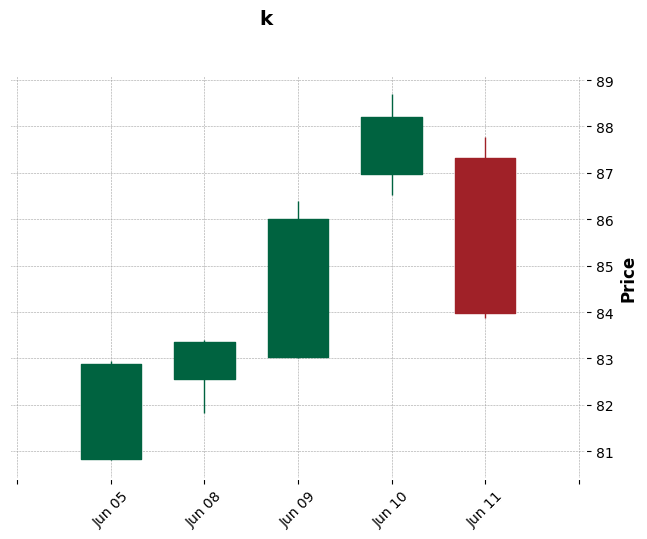

<Figure size 1000x500 with 0 Axes>

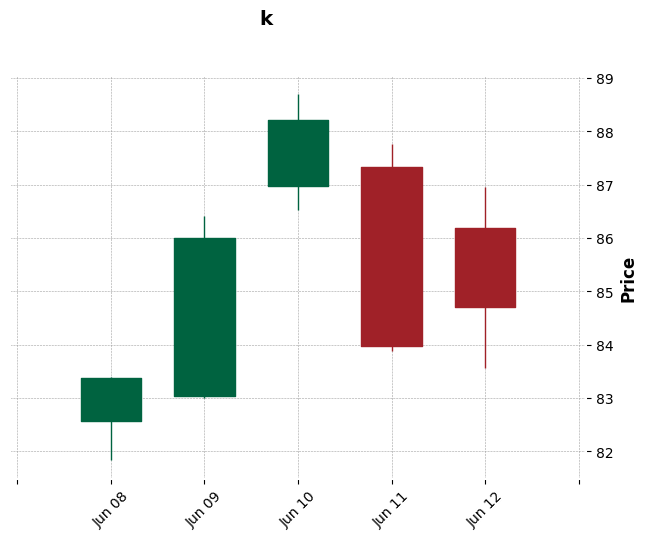

<Figure size 1000x500 with 0 Axes>

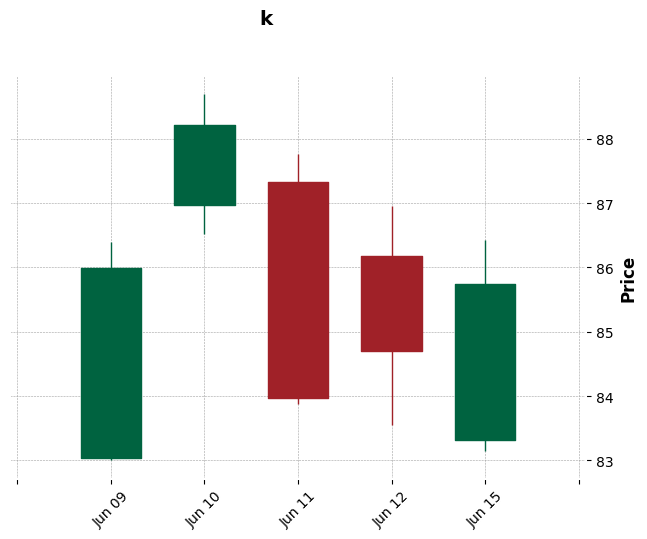

<Figure size 1000x500 with 0 Axes>

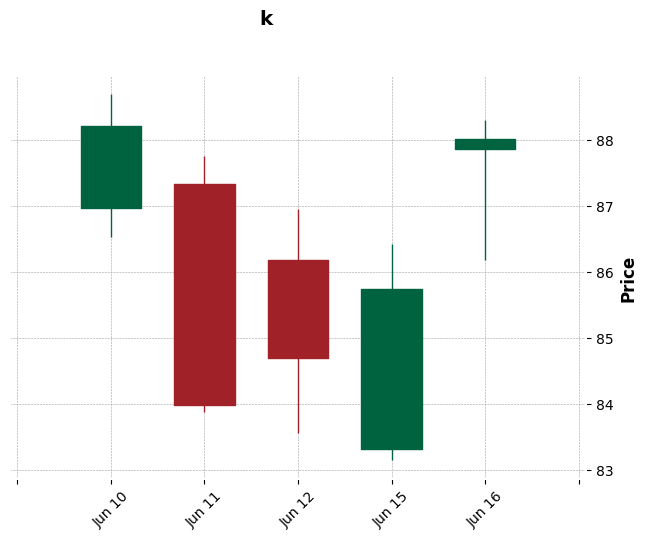

<Figure size 1000x500 with 0 Axes>

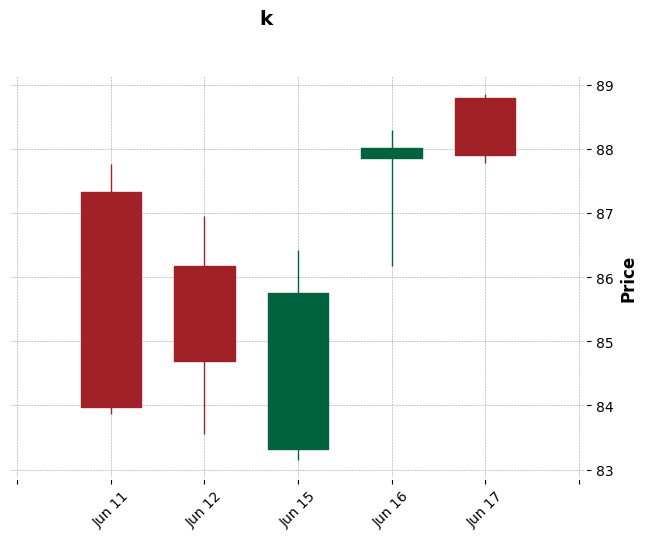

<Figure size 1000x500 with 0 Axes>

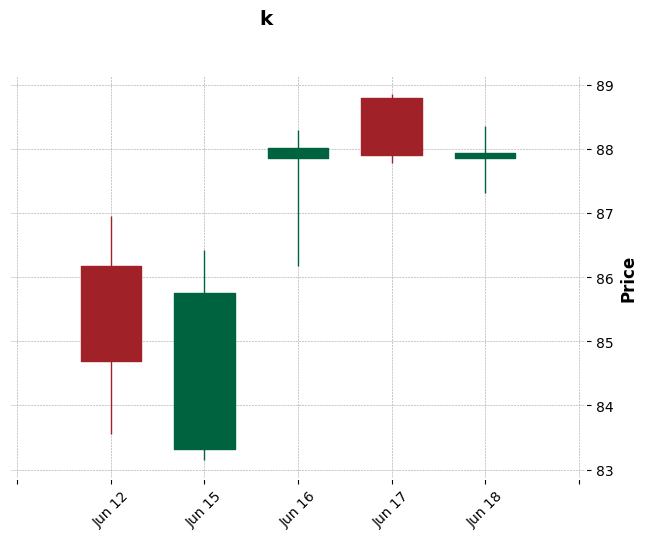

<Figure size 1000x500 with 0 Axes>

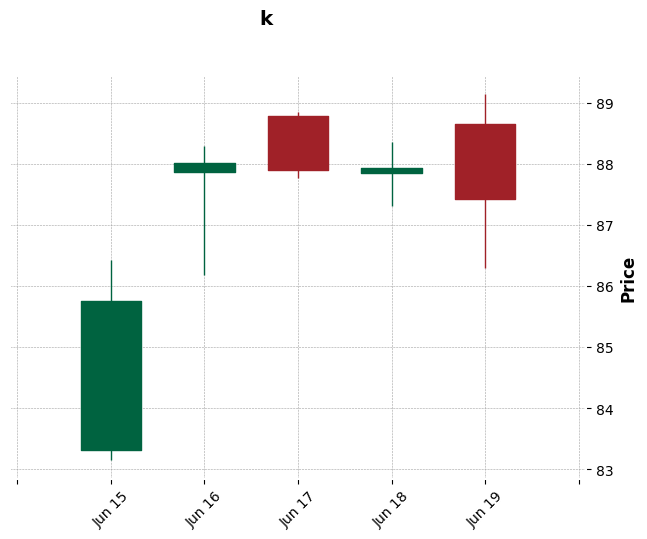

<Figure size 1000x500 with 0 Axes>

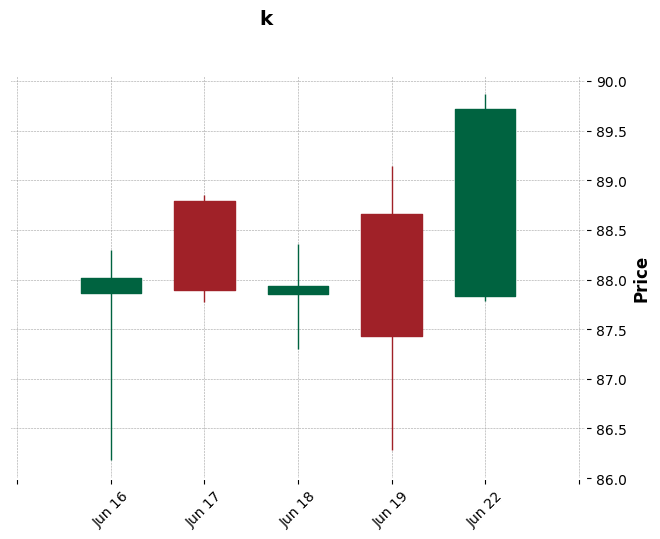

<Figure size 1000x500 with 0 Axes>

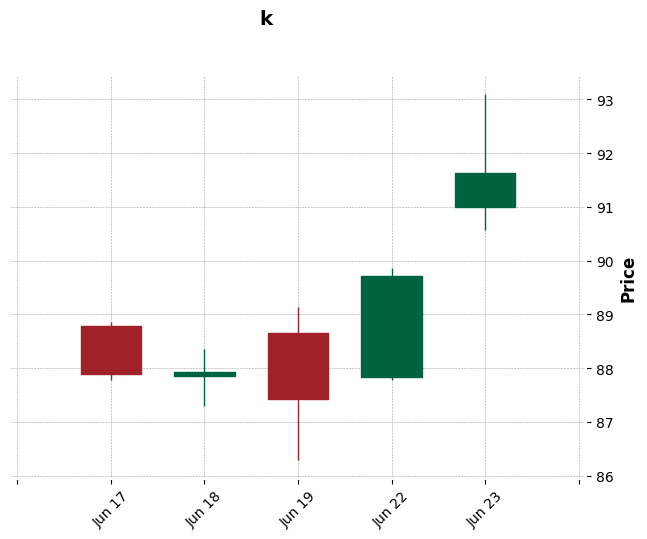

<Figure size 1000x500 with 0 Axes>

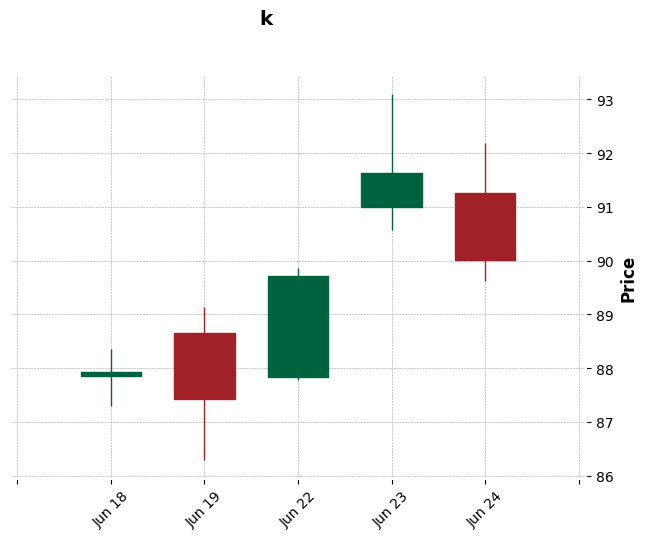

<Figure size 1000x500 with 0 Axes>

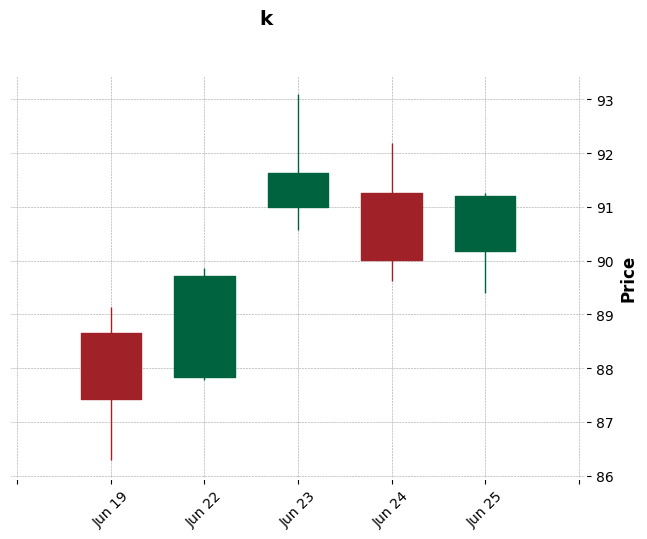

<Figure size 1000x500 with 0 Axes>

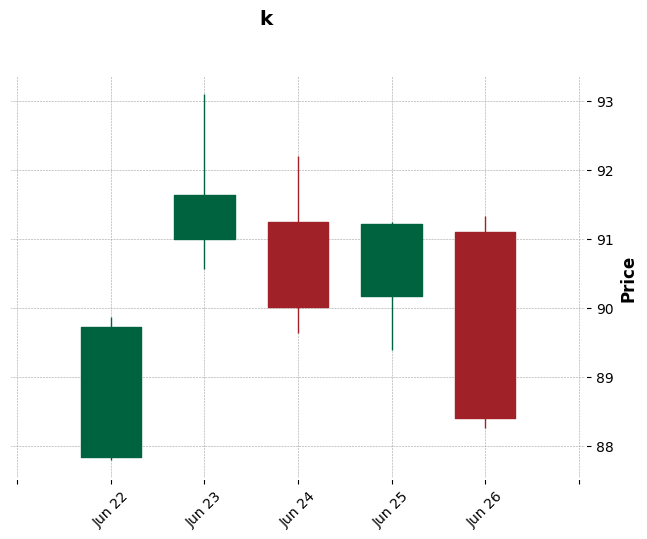

<Figure size 1000x500 with 0 Axes>

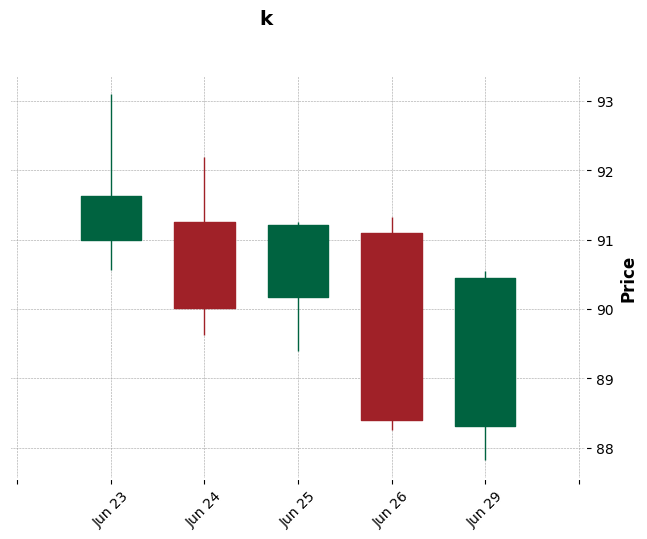

<Figure size 1000x500 with 0 Axes>

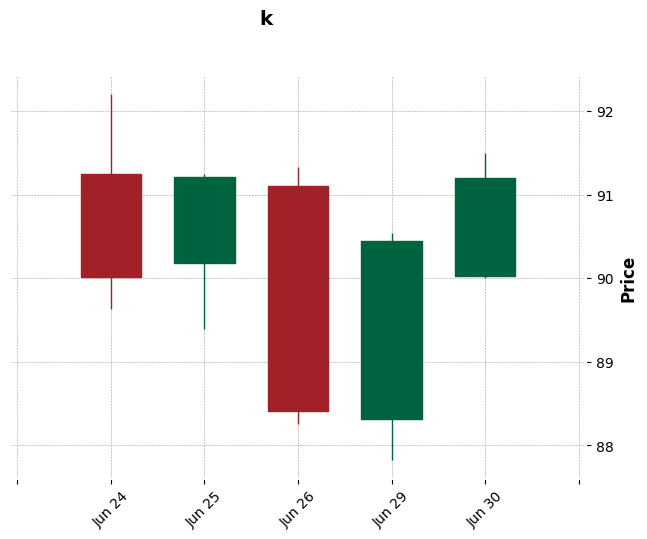

<Figure size 1000x500 with 0 Axes>

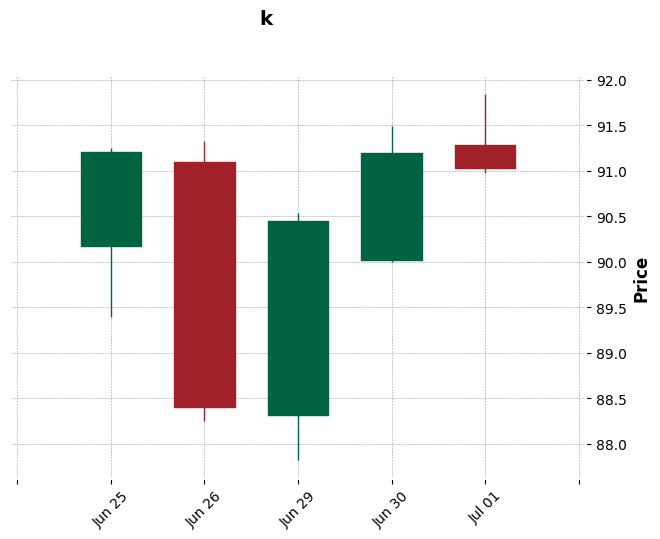

<Figure size 1000x500 with 0 Axes>

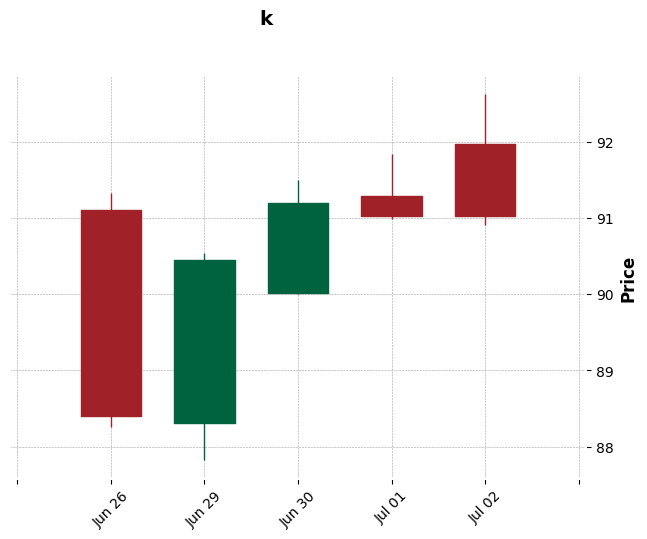

<Figure size 1000x500 with 0 Axes>

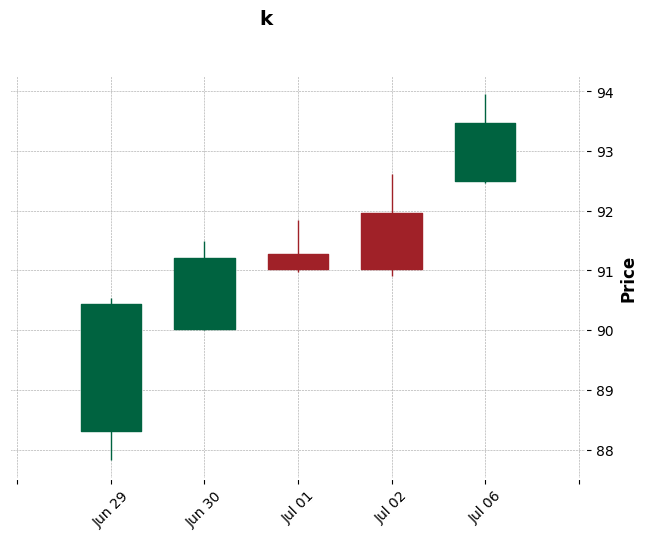

<Figure size 1000x500 with 0 Axes>

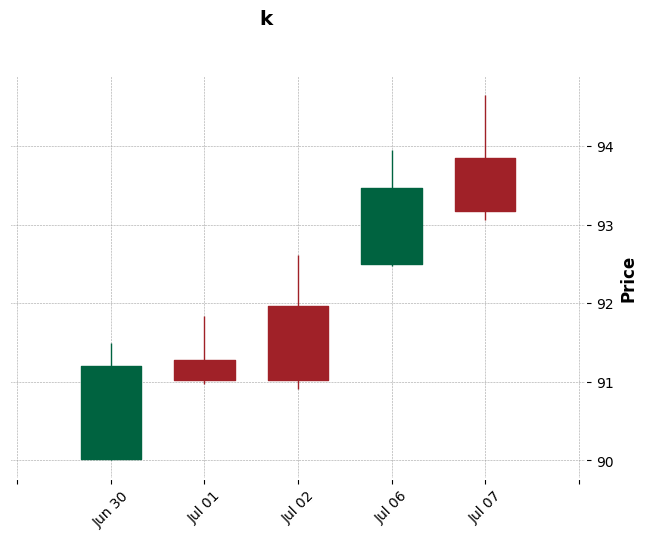

<Figure size 1000x500 with 0 Axes>

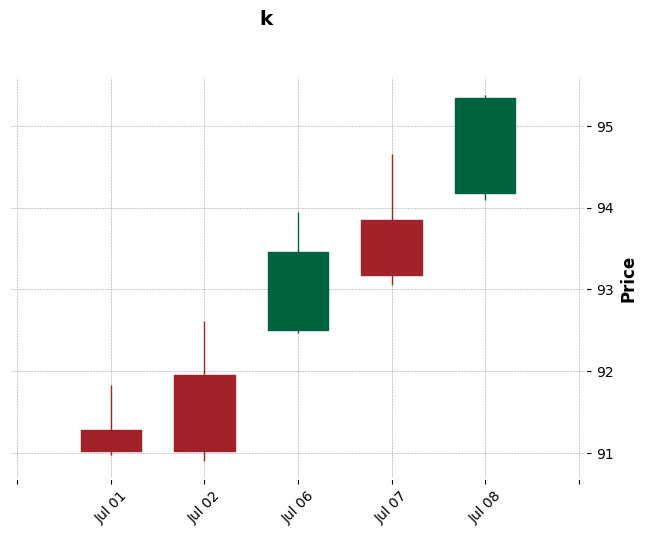

<Figure size 1000x500 with 0 Axes>

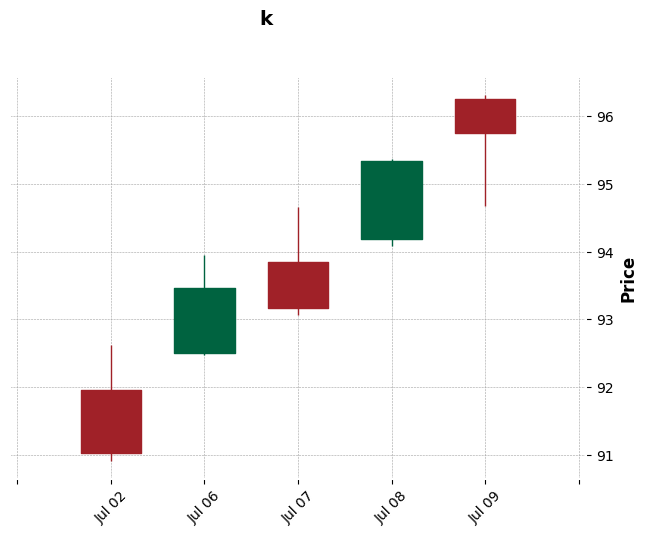

<Figure size 1000x500 with 0 Axes>

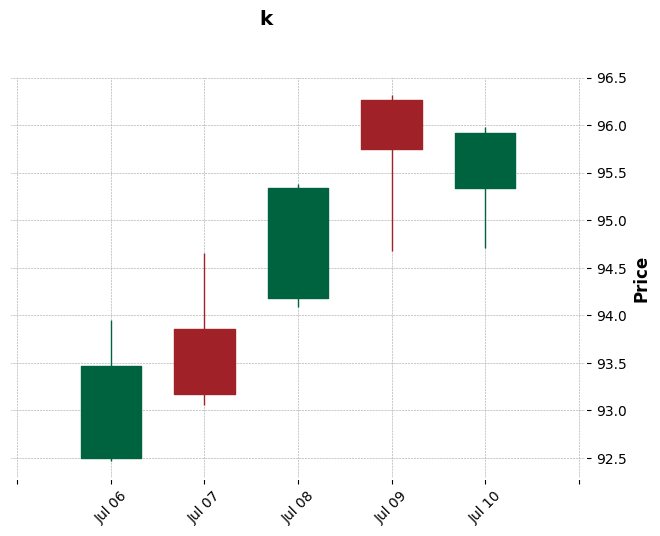

<Figure size 1000x500 with 0 Axes>

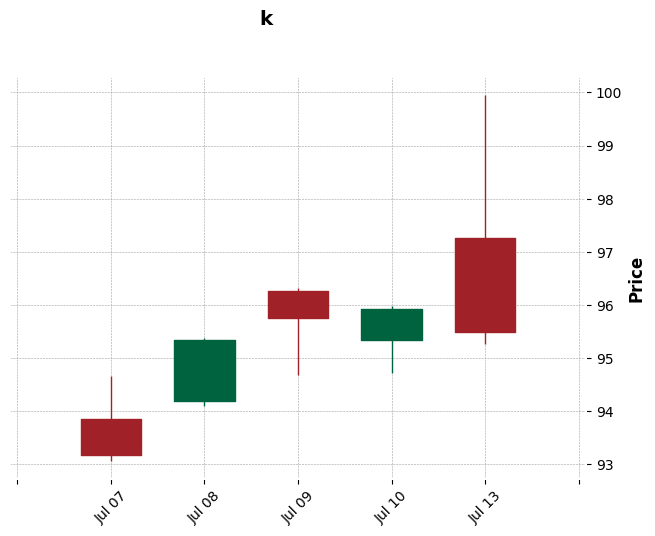

<Figure size 1000x500 with 0 Axes>

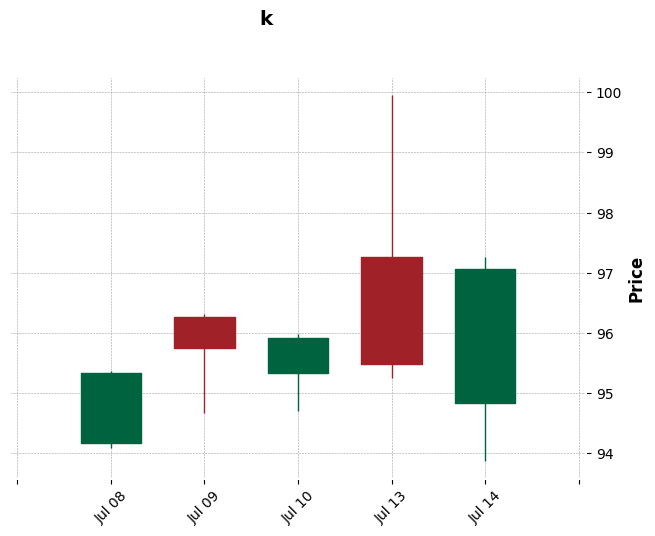

<Figure size 1000x500 with 0 Axes>

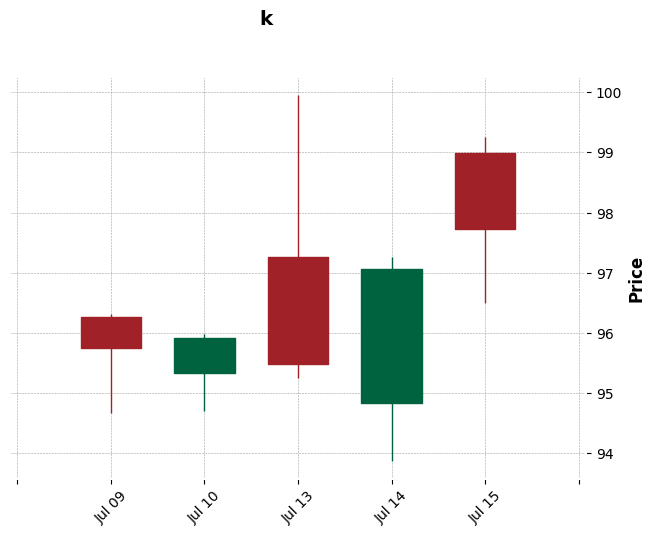

<Figure size 1000x500 with 0 Axes>

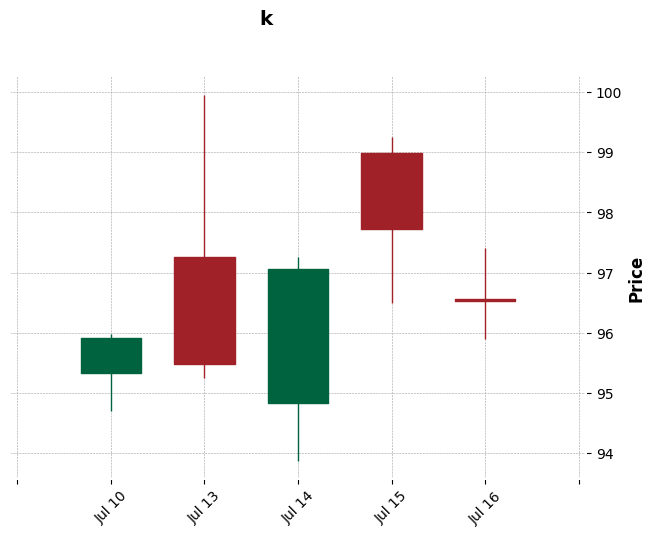

<Figure size 1000x500 with 0 Axes>

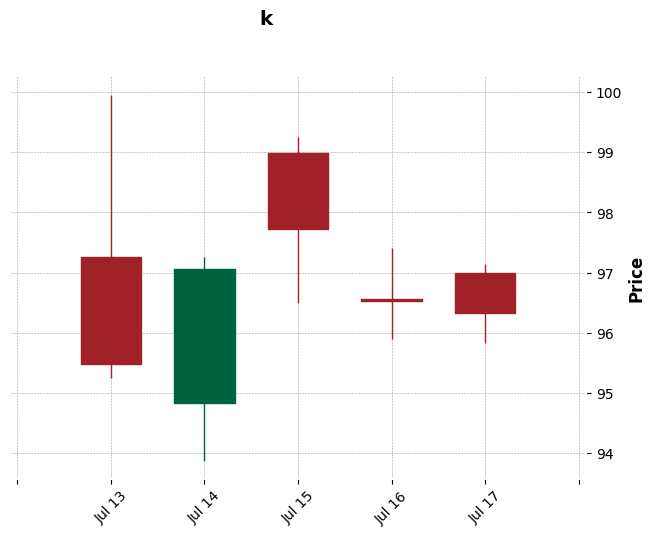

<Figure size 1000x500 with 0 Axes>

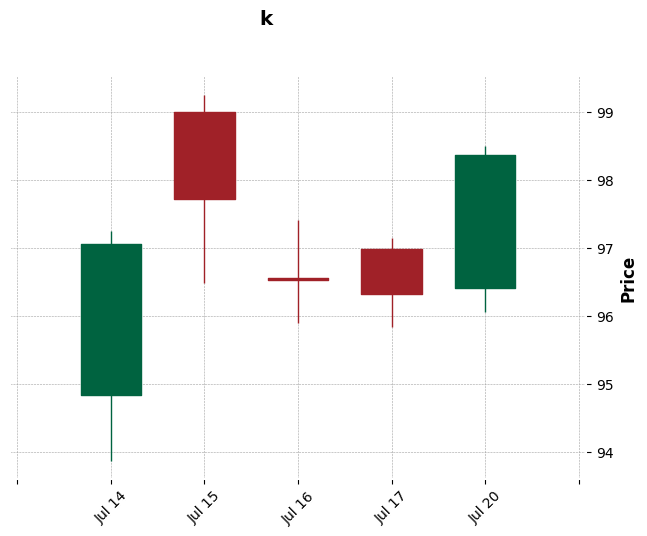

<Figure size 1000x500 with 0 Axes>

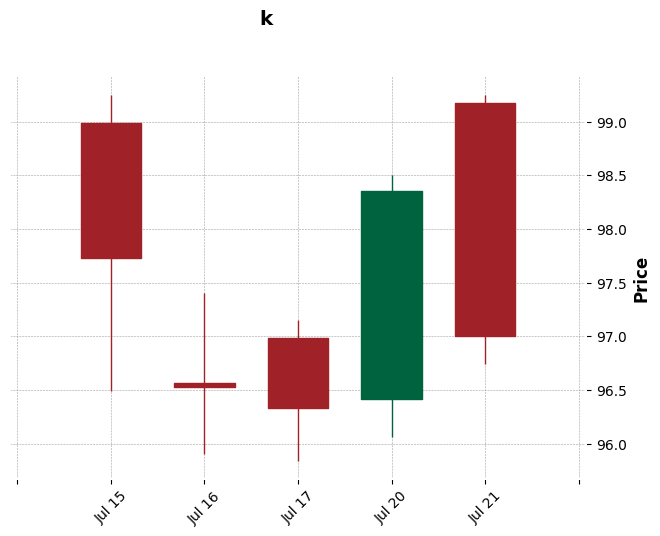

<Figure size 1000x500 with 0 Axes>

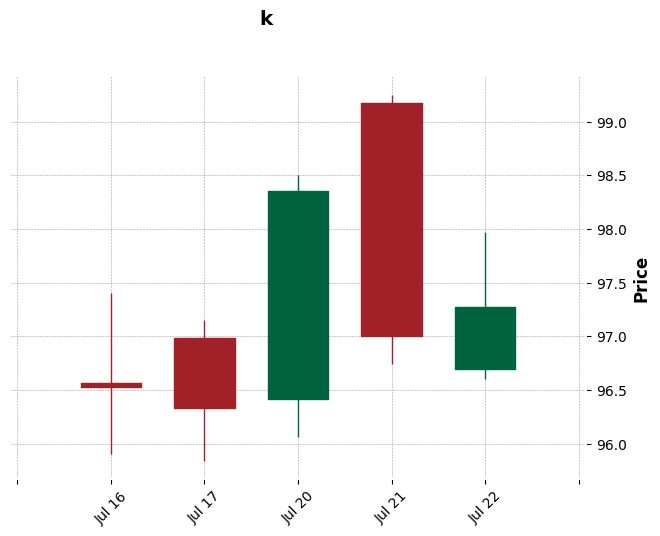

<Figure size 1000x500 with 0 Axes>

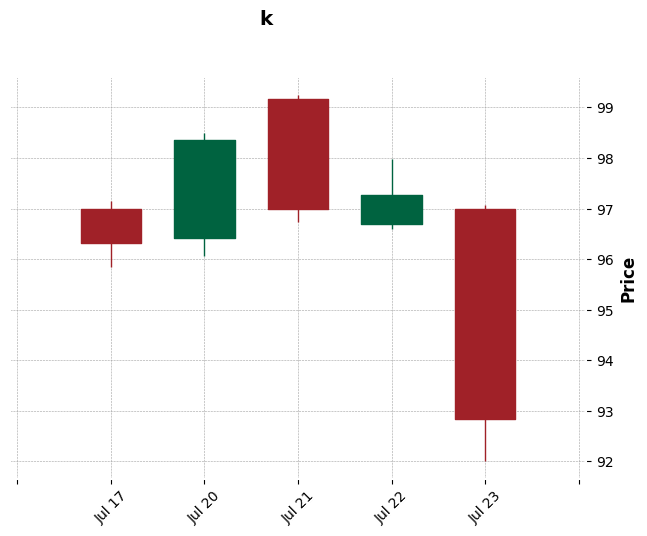

<Figure size 1000x500 with 0 Axes>

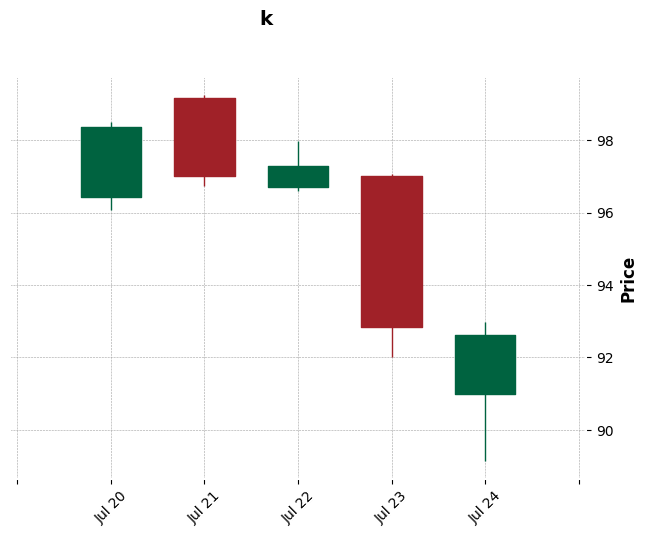

<Figure size 1000x500 with 0 Axes>

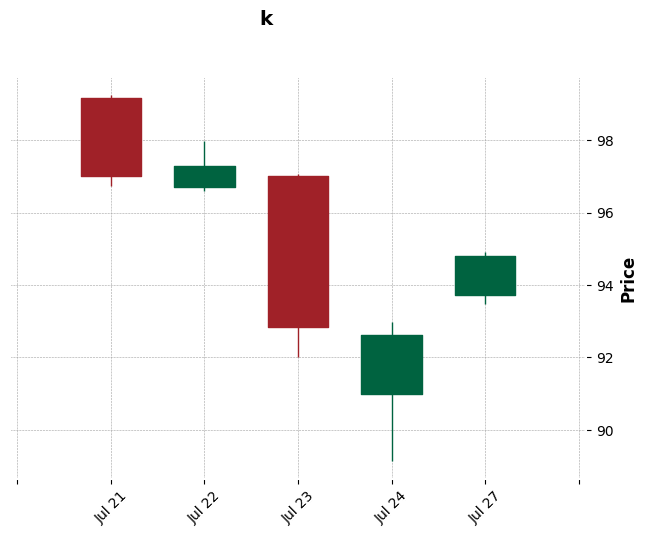

<Figure size 1000x500 with 0 Axes>

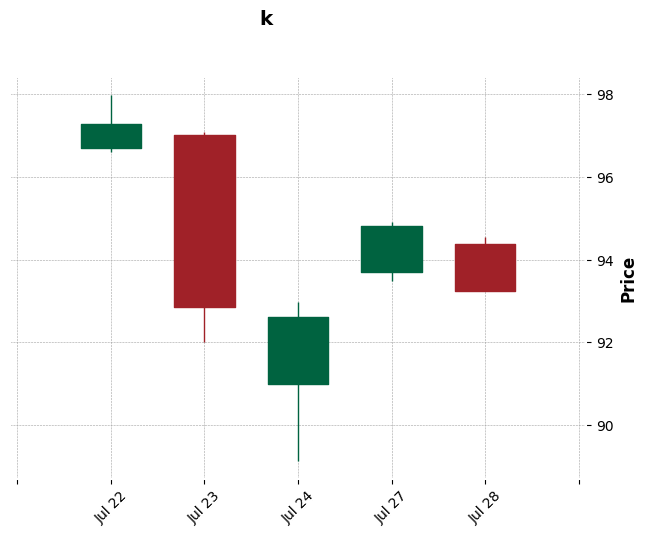

<Figure size 1000x500 with 0 Axes>

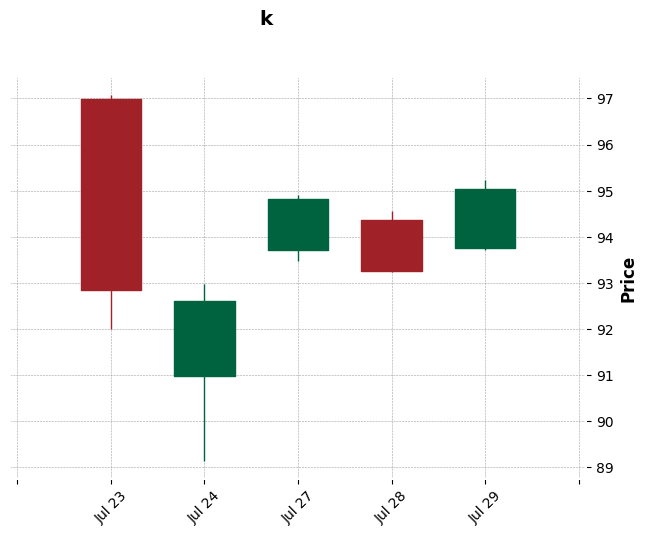

<Figure size 1000x500 with 0 Axes>

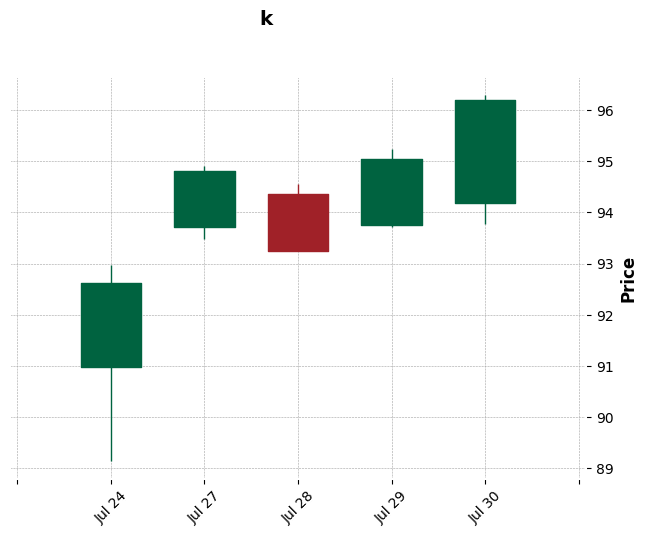

<Figure size 1000x500 with 0 Axes>

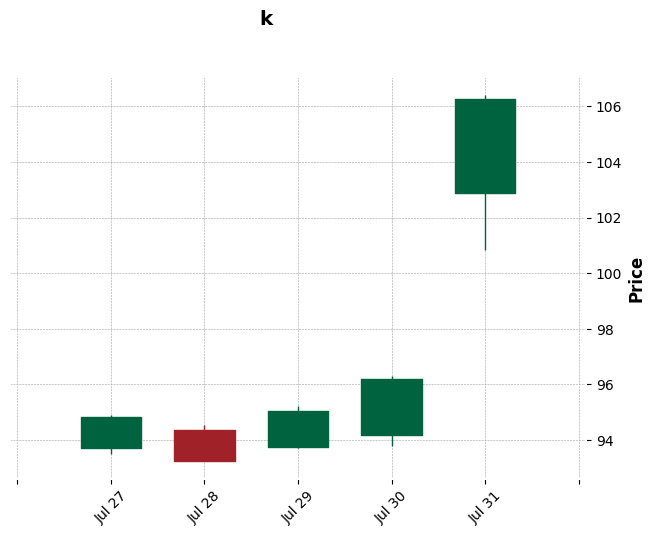

<Figure size 1000x500 with 0 Axes>

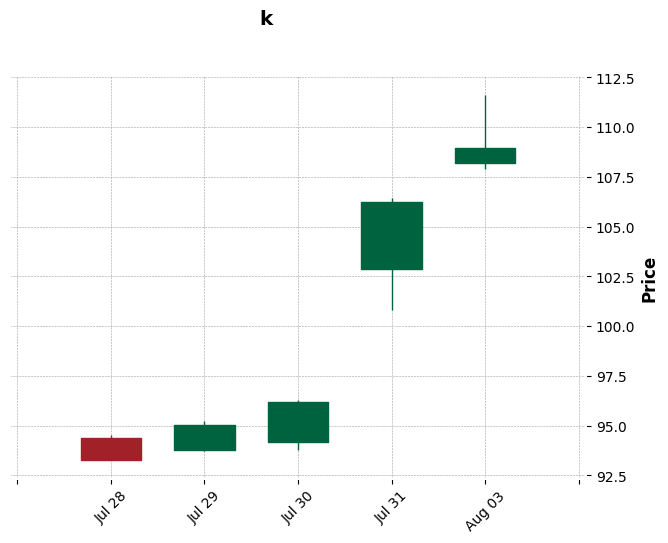

<Figure size 1000x500 with 0 Axes>

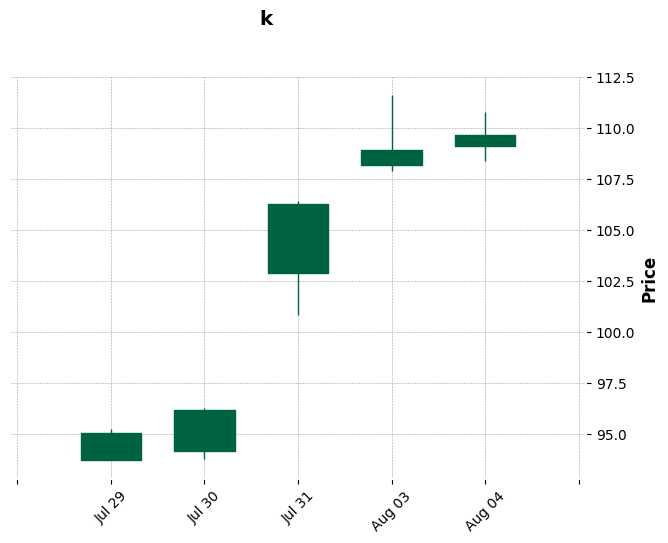

<Figure size 1000x500 with 0 Axes>

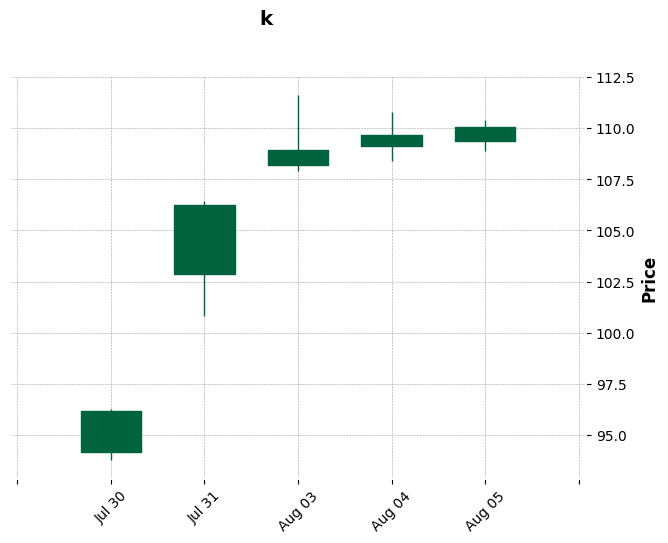

<Figure size 1000x500 with 0 Axes>

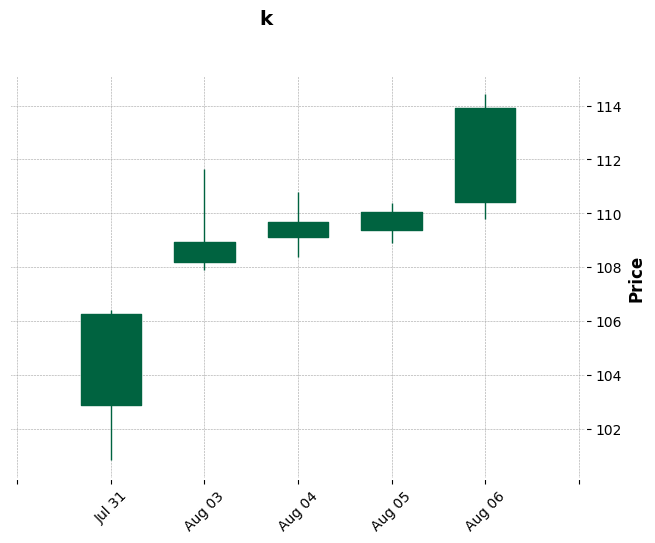

<Figure size 1000x500 with 0 Axes>

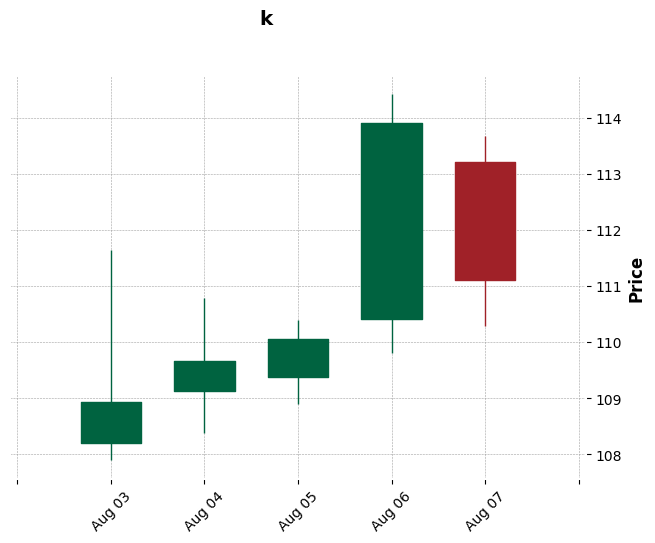

<Figure size 1000x500 with 0 Axes>

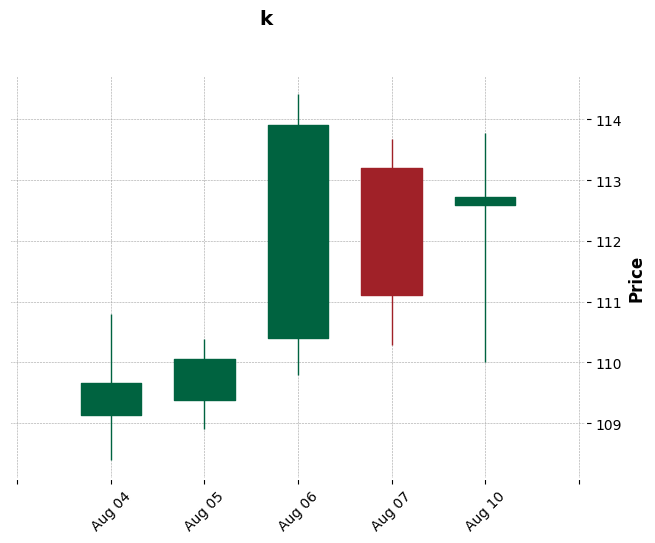

<Figure size 1000x500 with 0 Axes>

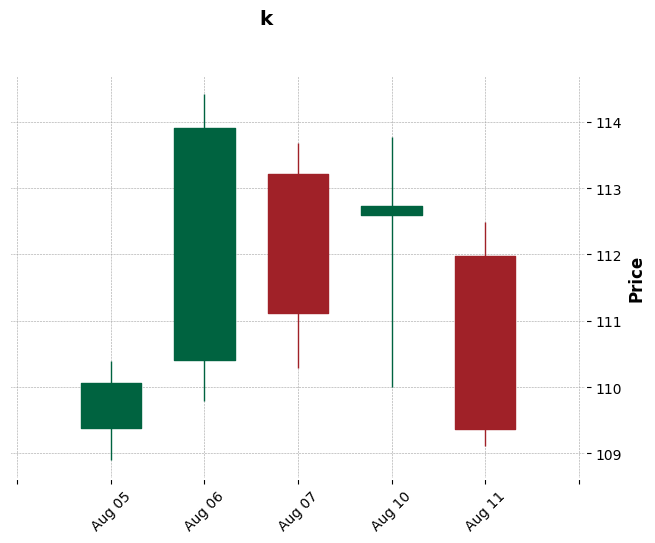

<Figure size 1000x500 with 0 Axes>

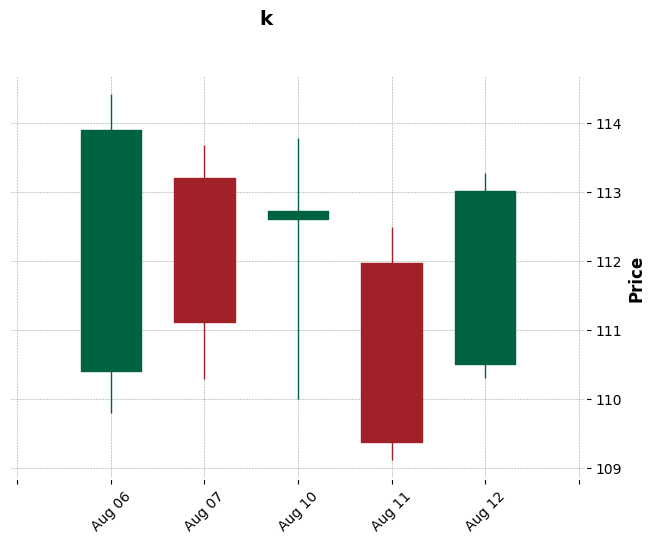

<Figure size 1000x500 with 0 Axes>

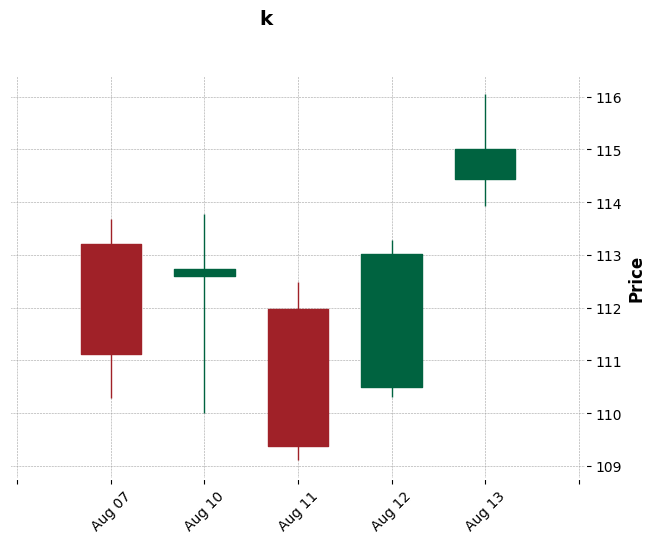

<Figure size 1000x500 with 0 Axes>

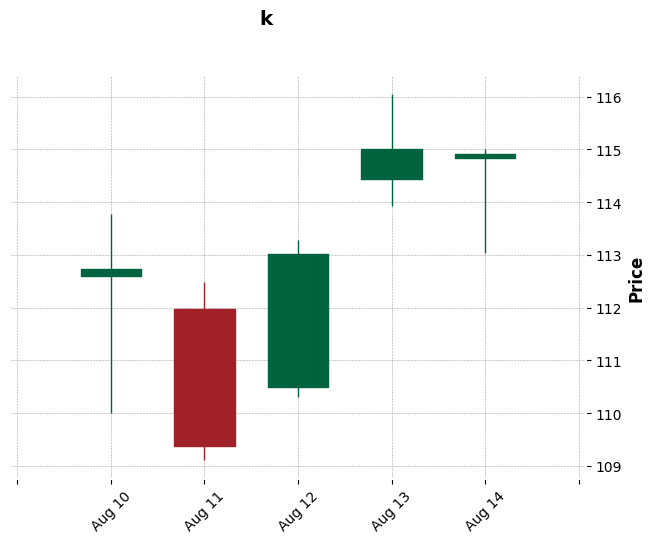

<Figure size 1000x500 with 0 Axes>

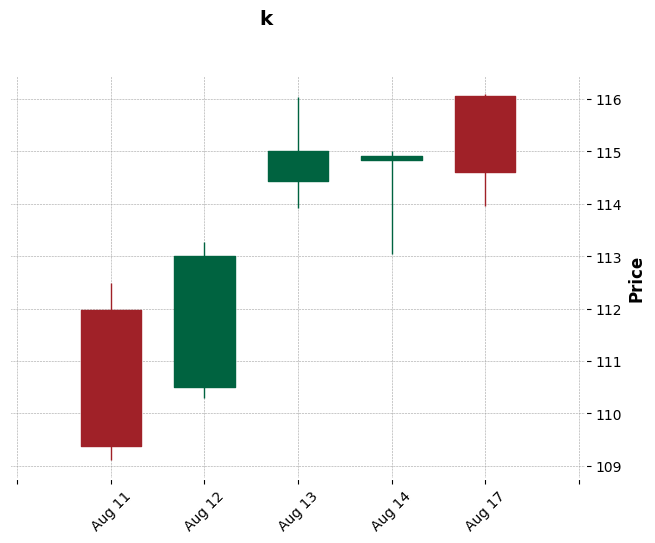

<Figure size 1000x500 with 0 Axes>

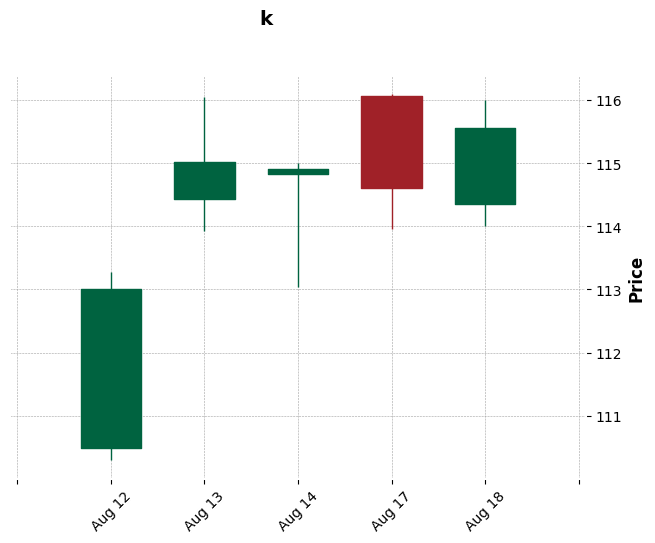

<Figure size 1000x500 with 0 Axes>

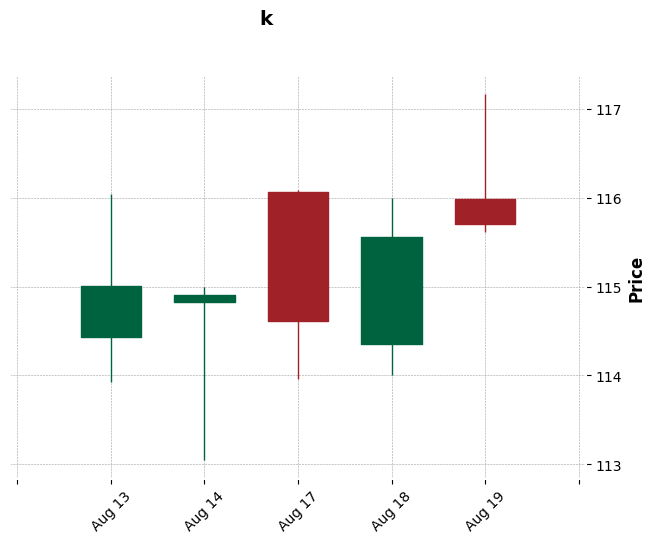

<Figure size 1000x500 with 0 Axes>

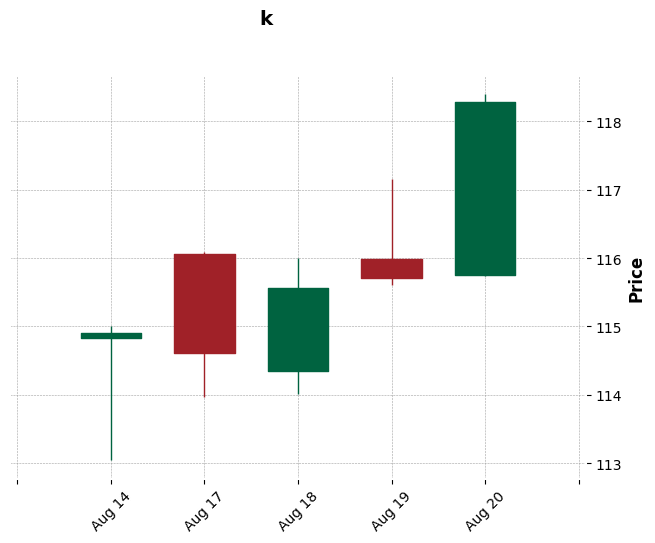

<Figure size 1000x500 with 0 Axes>

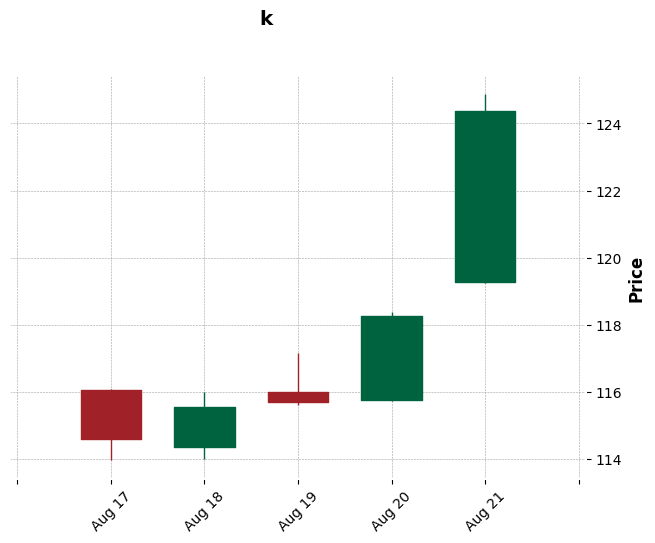

In [ ]:
import os
import yfinance as yf
import pandas as pd
import numpy as np
import mplfinance as mpf
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import shutil

# 1. 爬取股市資料
def fetch_stock_data(ticker, start_date, end_date):
    stock = yf.download(ticker, start=start_date, end=end_date)
    stock.columns = ['_'.join(col).strip() for col in stock.columns.values]
    stock.index = pd.to_datetime(stock.index)
    print("數據預覽：")
    print(stock.head())
    print("數據類型：")
    print(stock.dtypes)
    return stock

# 2. 計算技術指標和標註漲跌
def process_stock_data(stock_data):
    print("數據維度：", stock_data.shape)

    # 確保數據類型正確
    stock_data = stock_data.apply(pd.to_numeric, errors='coerce')
    if stock_data.isnull().values.any():
        print("數據中包含 NaN 值，請檢查數據源。")

    stock_data['MA5'] = stock_data['Close_AAPL'].rolling(window=5).mean()
    stock_data['MA10'] = stock_data['Close_AAPL'].rolling(window=10).mean()
    stock_data['Label'] = (stock_data['MA5'] > stock_data['MA10']).astype(int)
    stock_data.dropna(inplace=True)
    return stock_data

# 3. 繪製 K 線圖並儲存
def save_candlestick_image(data, filename):
    data = data[['Open_AAPL', 'High_AAPL', 'Low_AAPL', 'Close_AAPL']].copy()
    data.columns = ['Open', 'High', 'Low', 'Close']
    mpf.plot(data, type='candle', style='charles', savefig=filename)

# 4. 準備數據集
def prepare_dataset(stock_data, n_days):
    images = []
    labels = []
    for i in range(len(stock_data) - n_days):
        subset = stock_data.iloc[i:i + n_days]
        filename = f'candlestick_images/candlestick_{i}.png'
        save_candlestick_image(subset, filename)
        images.append(filename)
        labels.append(stock_data['Label'].iloc[i + n_days - 1])

    print(f'生成的圖像數量: {len(images)}, 標籤數量: {len(labels)}')
    return images, labels

# 5. 建立 CNN 模型
def create_model():
    model = models.Sequential()
    model.add(layers.Input(shape=(100, 100, 3)))
    model.add(layers.Conv2D(32, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.Flatten())
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(1, activation='sigmoid'))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model
import matplotlib.pyplot as plt

# 繪製 K 線圖和預測結果
def plot_candlestick_with_predictions(stock_data, predictions, n_days):
    # 確保 predictions 與 stock_data 的長度對齊
    predictions = np.array(predictions)

    # 繪製 K 線圖
    for i in range(len(predictions)):
        plt.figure(figsize=(10, 5))
        data_subset = stock_data.iloc[i:i + n_days][['Open_AAPL', 'High_AAPL', 'Low_AAPL', 'Close_AAPL']]
        data_subset.columns = ['Open', 'High', 'Low', 'Close']

        # 繪製 K 線圖
        mpf.plot(data_subset, type='candle', style='charles', title='k', ylabel='Price', volume=False)

        # 這裡可以根據需要顯示圖像
        plt.show()
# 主程式
def main():
    ticker = 'AAPL'
    start_date = '2020-01-01'
    end_date = '2023-01-01'
    n_days = 5

    # 1. 爬取資料
    stock_data = fetch_stock_data(ticker, start_date, end_date)

    # 2. 處理資料
    stock_data = process_stock_data(stock_data)

    # 3. 準備儲存 K 線圖
    if not os.path.exists('candlestick_images'):
        os.makedirs('candlestick_images')

    # 4. 準備數據集
    images, labels = prepare_dataset(stock_data, n_days)

    # 5. 切分數據集
    X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42)

    # 6. 數據增強
    train_datagen = ImageDataGenerator(rescale=1./255)
    test_datagen = ImageDataGenerator(rescale=1./255)

    # 建立目錄結構
    os.makedirs('candlestick_images/train/1', exist_ok=True)
    os.makedirs('candlestick_images/train/0', exist_ok=True)
    os.makedirs('candlestick_images/validation/1', exist_ok=True)
    os.makedirs('candlestick_images/validation/0', exist_ok=True)

    # 儲存訓練圖像
    for img, label in zip(images, labels):
        if label == 1:
            shutil.copy(img, 'candlestick_images/train/1/')
        else:
            shutil.copy(img, 'candlestick_images/train/0/')

    # 將 20% 的圖像分配到驗證集
    for img, label in zip(images[int(len(images) * 0.8):], labels[int(len(labels) * 0.8):]):
        if label == 1:
            shutil.copy(img, 'candlestick_images/validation/1/')
        else:
            shutil.copy(img, 'candlestick_images/validation/0/')

    # 7. 生成數據生成器
    train_generator = train_datagen.flow_from_directory(
        'candlestick_images/train',
        target_size=(100, 100),
        batch_size=32,
        class_mode='binary'
    )

    validation_generator = test_datagen.flow_from_directory(
        'candlestick_images/validation',
        target_size=(100, 100),
        batch_size=32,
        class_mode='binary'
    )

    # 8. 建立模型
    model = create_model()

    # 9. 訓練模型
    model.fit(train_generator, epochs=10, validation_data=validation_generator)
    test_images = X_test  # 這裡要根據實際測試數據修改
    predictions = model.predict(validation_generator)
    predictions = np.where(predictions > 0.5, 1, 0).flatten()  # 將預測轉換為類別標籤
    print("預測結果：",predictions)
    print("實際標籤：",y_test)
    plot_candlestick_with_predictions(stock_data, predictions, n_days)
if __name__ == "__main__":
    main()
